<div style="text-align: center; font-size: 18pt; font-weight: bold; line-height: 1.5;">
Machine Learning-Based Prediction of Health Conditions in the Elderly
</div>

<div style="text-align: center; font-size: 15pt; ">
DSA5105 Project
</div>

---

<div style="text-align: center; font-size: 14pt; line-height: 1.5;">
QIN JIAYUE   
</div>

<div style="text-align: center; font-size: 14pt; line-height: 1.5;">
A0294788B 
</div>

<div style="text-align: center; font-size: 14pt; line-height: 1.5;">
Data Science and Machine Learning 
</div>

<div style="text-align: center; font-size: 14pt; line-height: 1.5;">
National University of Singapore
</div>

<div style="text-align: center; font-size: 14pt; line-height: 1.5;">
e1348926@u.nus.edu  
</div>
    
---

<div style="text-align: center; font-size: 12pt;">
November 21, 2024
</div>


# 1. Introduction

With the global population aging rapidly, elderly health issues have become a critical concern. Aging weakens physical functions and immune systems, increasing susceptibility to chronic diseases like hypertension and diabetes, which burden individuals and healthcare systems. Advanced bioinformatics and machine learning techniques enable early disease detection and treatment, improving health outcomes while optimizing medical resources. These innovations foster a fairer, more efficient healthcare system, laying the groundwork for a healthier society.

To explore these opportunities, this notebook is structured as follows:

1. **Section 2**: Initial exploration of the dataset, including an overview of the data sources, the content and meaning of various variables, and data visualization.

2. **Section 3**: Introduction of the supervised and unsupervised learning methods employed in this project, as well as the performance metrics used for classification evaluation.

3. **Section 4**: Data preprocessing and feature engineering, followed by determining the data splitting strategy. Based on this, several models are developed and their initial performances compared, including Decision Tree, LightGBM, Random Forest, and Support Vector Classifier (SVC). The better-performing models (LightGBM, Random Forest, and SVC) are further optimized through hyperparameter tuning, and model explainability is enhanced by analyzing feature importance.

4. **Section 5**: Evaluation of the predictive performance of the final model, along with reflections on the research process, lessons learned, and potential directions for future improvement.

The workflow of this study is summarized in the figure below.

<div style="text-align: center;">
    <img src="./tmp_results/flow.png" alt="Workflow Overview" style="width:50%;"/>
</div>

<div style="text-align: center; font-size: 10pt; ">
Figure 1: Study workflow
</div>

# 2. Dataset Overview

## 2.1 Dataset Description

The dataset used in this study originates from InVitro Cell Research, LLC (ICR), a privately funded company specializing in regenerative and personalized preventive medicine. The data was collected by ICR scientists and is available through the Kaggle competition "[ICR - Identifying Age-Related Conditions](https://www.kaggle.com/competitions/icr-identify-age-related-conditions/data)."

The competition provides four datasets: `train`, `test`, `greeks`, and `sample_submission`.


<div style="font-size: 12pt; font-weight: bold; line-height: 1.5;">
1. Train Dataset
</div>

The `train` dataset, provided for training purposes, consists of 617 samples, some of which contain missing values. It includes information about elderly individuals from various regions and ethnic backgrounds. The dataset contains:
- **Id**: A unique identifier for each observation.
- **AB-GL**: 56 anonymized health characteristics. All features are numeric except for `EJ`, which is categorical.
- **Target variable (`Class`)**: A binary variable where:
  - `0`: Indicates no diagnosis of any of the three specified diseases.
  - `1`: Indicates a diagnosis of one or more of the three diseases.

<div style="font-size: 12pt; font-weight: bold; line-height: 1.5;">
2. Test Dataset
</div>

The `test` dataset is provided to predict the probability of a sample belonging to one of the two classes (`0` or `1`). This dataset is used for final model evaluation.

<div style="font-size: 12pt; font-weight: bold; line-height: 1.5;">
3. Greeks Dataset
</div>

The `greeks` dataset is exclusively for the training data. It contains:
- **Alpha**: Indicates the presence of diseases where:
  - `A`: No diagnosis (corresponding to `Class = 0`).
  - `B, D, G`: Diagnosis of one specific disease (corresponding to `Class = 1`).
- **Beta, Gamma, and Delta**: Experimental features.
- **Epsilon**: A date feature representing the data collection timeline. 
  - According to the competition, all data in the test dataset was collected after the training dataset.

<div style="font-size: 12pt; font-weight: bold; line-height: 1.5;">
4. Sample Submission Dataset
</div>

The `sample_submission` dataset provides a template for the required structure and format of submission files, serving as a reference for participants.

The modeling in this study is conducted exclusively using the `train` dataset, as the `test` dataset does not have a corresponding `Greeks` dataset. To ensure the generalizability and robustness of the model, the `Greeks` dataset is excluded from the analysis. This approach avoids reliance on additional features unavailable in the `test` dataset, ensuring a fair and consistent evaluation of the model's performance.

In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
%matplotlib inline
import seaborn as sns
import gc
import re as re
from collections import Counter
from sklearn.preprocessing import LabelEncoder,StandardScaler
import warnings
warnings.filterwarnings('ignore')

In [2]:
read_path = './icr-identify-age-related-conditions/'
save_path = './tmp_results/'

In [3]:
# load datasets
train             = pd.read_csv(read_path + 'train.csv')
test              = pd.read_csv(read_path + 'test.csv')
greeks            = pd.read_csv(read_path + 'greeks.csv')
submission_df = pd.read_csv(read_path + 'sample_submission.csv')

train.head()

,Id,AB,AF,AH,AM,AR,AX,AY,AZ,BC,BD,BN,BP,BQ,BR,BZ,CB,CC,CD,CF,CH,CL,CR,CS,CU,CW,DA,DE,DF,DH,DI,DL,DN,DU,DV,DY,EB,EE,EG,EH,EJ,EL,EP,EU,FC,FD,FE,FI,FL,FR,FS,GB,GE,GF,GH,GI,GL,Class
0,000ff2bfdfe9,0.209377,3109.03329,85.200147,22.394407,8.138688,0.699861,0.025578,9.812214,5.555634,4126.58731,22.5984,175.638726,152.707705,823.928241,257.432377,47.223358,0.563481,23.387600,4.851915,0.023482,1.050225,0.069225,13.784111,1.302012,36.205956,69.08340,295.570575,0.23868,0.284232,89.245560,84.31664,29.657104,5.310690,1.74307,23.187704,7.294176,1.987283,1433.166750,0.949104,B,30.879420,78.526968,3.828384,13.394640,10.265073,9028.291921,3.583450,7.298162,1.73855,0.094822,11.339138,72.611063,2003.810319,22.136229,69.834944,0.120343,1
1,007255e47698,0.145282,978.76416,85.200147,36.968889,8.138688,3.632190,0.025578,13.517790,1.229900,5496.92824,19.4205,155.868030,14.754720,51.216883,257.432377,30.284345,0.484710,50.628208,6.085041,0.031442,1.113875,1.117800,28.310953,1.357182,37.476568,70.79836,178.553100,0.23868,0.363489,110.581815,75.74548,37.532000,0.005518,1.74307,17.222328,4.926396,0.858603,1111.287150,0.003042,A,109.125159,95.415086,52.260480,17.175984,0.296850,6785.003474,10.358927,0.173229,0.49706,0.568932,9.292698,72.611063,27981.562750,29.135430,32.131996,21.978000,0
2,013f2bd269f5,0.470030,2635.10654,85.200147,32.360553,8.138688,6.732840,0.025578,12.824570,1.229900,5135.78024,26.4825,128.988531,219.320160,482.141594,257.432377,32.563713,0.495852,85.955376,5.376488,0.036218,1.050225,0.700350,39.364743,1.009611,21.459644,70.81970,321.426625,0.23868,0.210441,120.056438,65.46984,28.053464,1.289739,1.74307,36.861352,7.813674,8.146651,1494.076488,0.377208,B,109.125159,78.526968,5.390628,224.207424,8.745201,8338.906181,11.626917,7.709560,0.97556,1.198821,37.077772,88.609437,13676.957810,28.022851,35.192676,0.196941,0
3,043ac50845d5,0.252107,3819.65177,120.201618,77.112203,8.138688,3.685344,0.025578,11.053708,1.229900,4169.67738,23.6577,237.282264,11.050410,661.518640,257.432377,15.201914,0.717882,88.159360,2.347652,0.029054,1.400300,0.636075,41.116960,0.722727,21.530392,47.27586,196.607985,0.23868,0.292431,139.824570,71.57120,24.354856,2.655345,1.74307,52.003884,7.386060,3.813326,15691.552180,0.614484,B,31.674357,78.526968,31.323372,59.301984,7.884336,10965.766040,14.852022,6.122162,0.49706,0.284466,18.529584,82.416803,2094.262452,39.948656,90.493248,0.155829,0
4,044fb8a146ec,0.380297,3733.04844,85.200147,14.103738,8.138688,3.942255,0.054810,3.396778,102.151980,5728.73412,24.0108,324.546318,149.717165,6074.859475,257.432377,82.213495,0.536467,72.644264,30.537722,0.025472,1.050225,0.693150,31.724726,0.827550,34.415360,74.06532,200.178160,0.23868,0.207708,97.920120,52.83888,26.019912,1.144902,1.74307,9.064856,7.350720,3.490846,1403.656300,0.164268,B,109.125159,91.994825,51.141336,29.102640,4.274640,16198.049590,13.666727,8.153058,48.50134,0.121914,16.408728,146.109943,8524.370502,45.381316,36.262628,0.096614,1


In [4]:
greeks.head()

,Id,Alpha,Beta,Gamma,Delta,Epsilon
0,000ff2bfdfe9,B,C,G,D,3/19/2019
1,007255e47698,A,C,M,B,Unknown
2,013f2bd269f5,A,C,M,B,Unknown
3,043ac50845d5,A,C,M,B,Unknown
4,044fb8a146ec,D,B,F,B,3/25/2020


In [5]:
# Getting the shape of the train DataFrame
train_rows, train_columns = train.shape

# Getting the shape of the test DataFrame
test_rows, test_columns = test.shape

# Printing the number of rows and columns for train and test DataFrames
print("Train DataFrame - Rows:", train_rows, ", Columns:", train_columns)
print("Test DataFrame - Rows:", test_rows, ", Columns:", test_columns)

Train DataFrame - Rows: 617 , Columns: 58
Test DataFrame - Rows: 5 , Columns: 57


In [6]:
# Printing the column names of the train DataFrame
print("Column names in the train DataFrame:")
print(train.columns.tolist())

Column names in the train DataFrame:
['Id', 'AB', 'AF', 'AH', 'AM', 'AR', 'AX', 'AY', 'AZ', 'BC', 'BD ', 'BN', 'BP', 'BQ', 'BR', 'BZ', 'CB', 'CC', 'CD ', 'CF', 'CH', 'CL', 'CR', 'CS', 'CU', 'CW ', 'DA', 'DE', 'DF', 'DH', 'DI', 'DL', 'DN', 'DU', 'DV', 'DY', 'EB', 'EE', 'EG', 'EH', 'EJ', 'EL', 'EP', 'EU', 'FC', 'FD ', 'FE', 'FI', 'FL', 'FR', 'FS', 'GB', 'GE', 'GF', 'GH', 'GI', 'GL', 'Class']


In [7]:
# Getting the unique values in the 'EJ' column
unique_values_EJ = train['EJ'].unique()

# Displaying the unique values in the 'EJ' column
print("Unique values in the 'EJ' column:")
print(unique_values_EJ)

Unique values in the 'EJ' column:
['B' 'A']


In [8]:
#Train Dataset Descriptive statistics
features = [
    'AB', 'AF', 'AH', 'AM', 'AR', 'AX', 'AY', 'AZ', 'BC', 'BD ', 'BN',
    'BP', 'BQ', 'BR', 'BZ', 'CB', 'CC', 'CD ', 'CF', 'CH', 'CL', 'CR', 'CS',
    'CU', 'CW ', 'DA', 'DE', 'DF', 'DH', 'DI', 'DL', 'DN', 'DU', 'DV', 'DY',
    'EB', 'EE', 'EG', 'EH', 'EJ', 'EL', 'EP', 'EU', 'FC', 'FD ', 'FE', 'FI',
    'FL', 'FR', 'FS', 'GB', 'GE', 'GF', 'GH', 'GI', 'GL'
]

train[features].describe().T.style.bar(subset=['mean'], color='#7BCC70')\
    .background_gradient(subset=['std'], cmap='Reds')\
    .background_gradient(subset=['50%'], cmap='coolwarm')

,count,mean,std,min,25%,50%,75%,max
AB,617.000000,0.477149,0.468388,0.081187,0.252107,0.354659,0.559763,6.161666
AF,617.000000,3502.013221,2300.322717,192.593280,2197.345480,3120.318960,4361.637390,28688.187660
AH,617.000000,118.624513,127.838950,85.200147,85.200147,85.200147,113.739540,1910.123198
AM,617.000000,38.968552,69.728226,3.177522,12.270314,20.533110,39.139886,630.518230
AR,617.000000,10.128242,10.518877,8.138688,8.138688,8.138688,8.138688,178.943634
AX,617.000000,5.545576,2.551696,0.699861,4.128294,5.031912,6.431634,38.270880
AY,617.000000,0.060320,0.416817,0.025578,0.025578,0.025578,0.036845,10.315851
AZ,617.000000,10.566447,4.350645,3.396778,8.129580,10.461320,12.969516,38.971568
BC,617.000000,8.053012,65.166943,1.229900,1.229900,1.229900,5.081244,1463.693448
BD,617.000000,5350.388655,3021.326641,1693.624320,4155.702870,4997.960730,6035.885700,53060.599240


The output indicates that the scales of the features vary significantly. Therefore, it is necessary to standardize them to a uniform scale during subsequent dimensionality reduction and modeling processes.

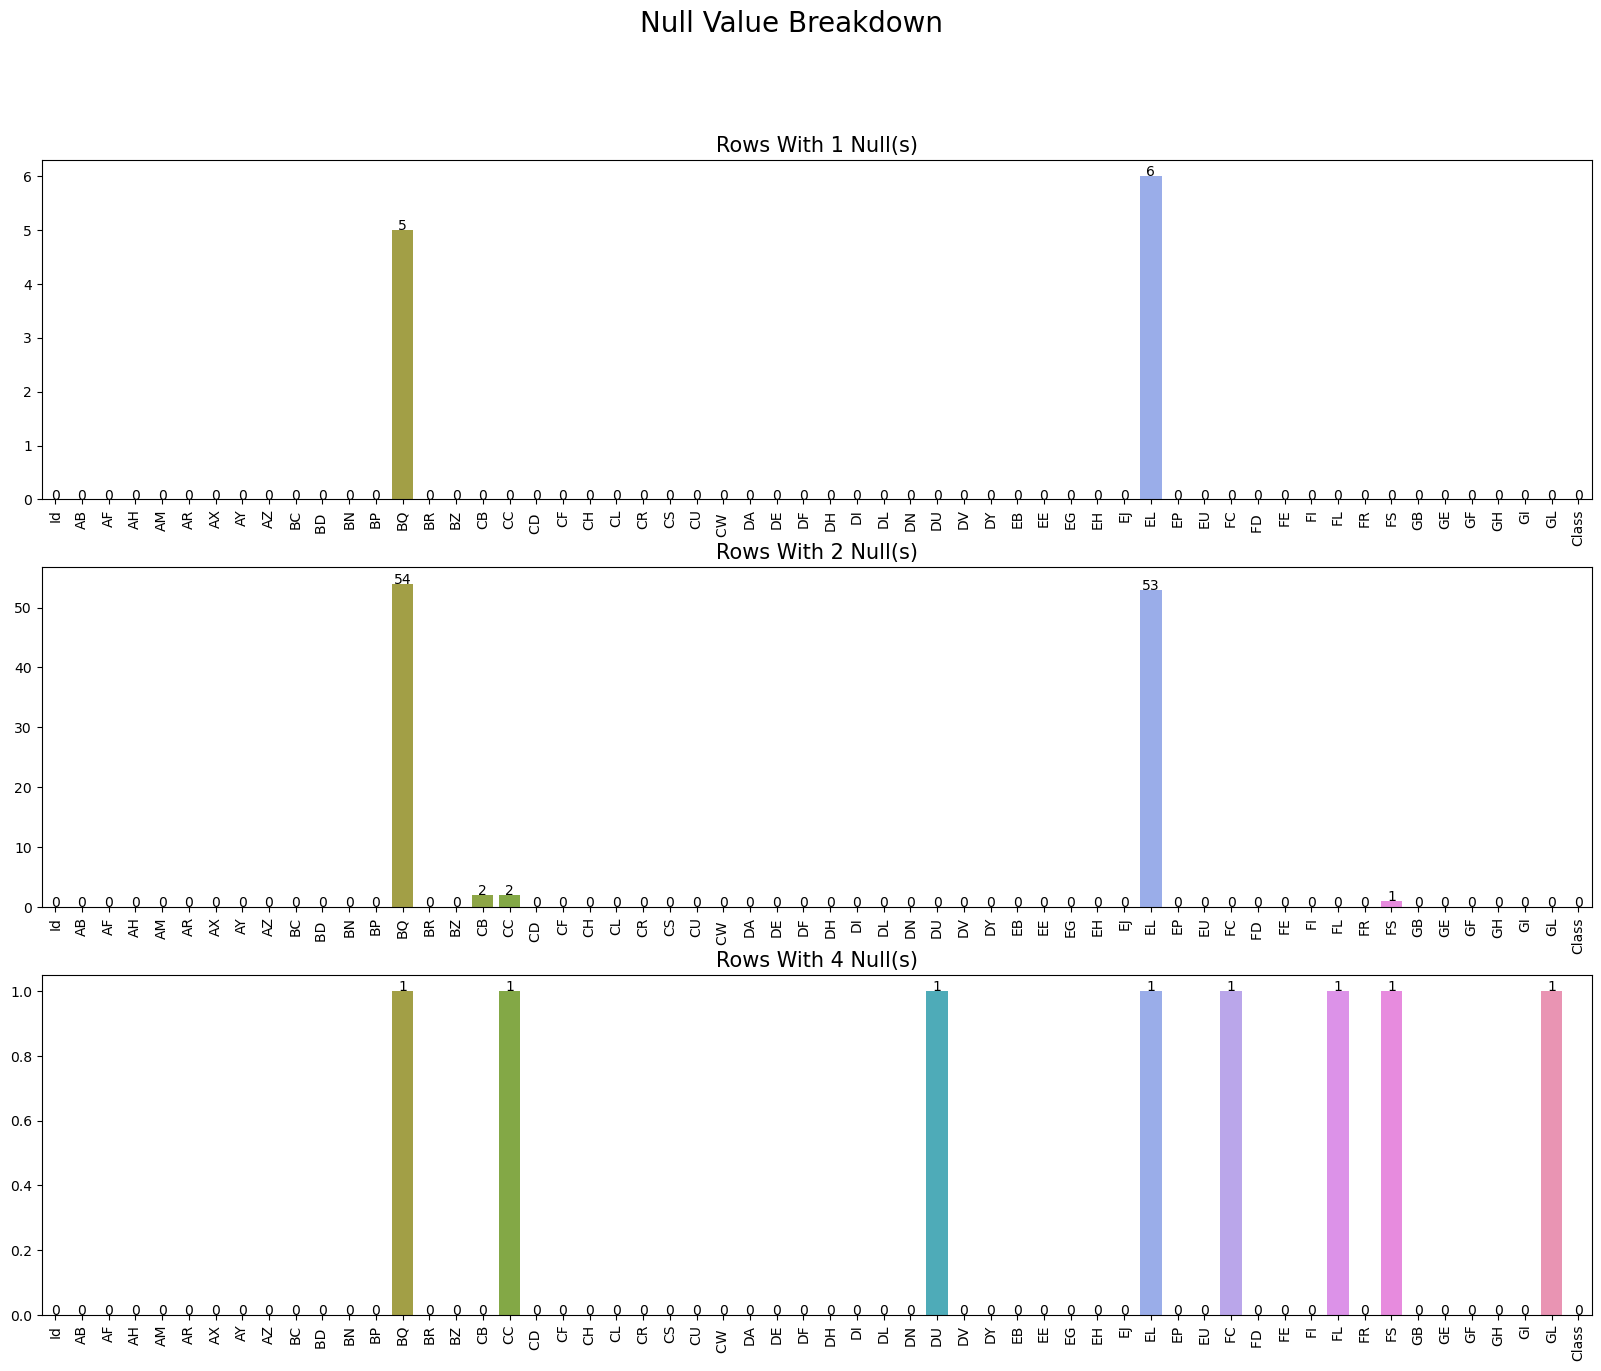

In [9]:
# Analyzing Missing Values in the Dataset

# Add a new column to count the number of missing values in each row
train["null_count"] = train.isnull().sum(axis=1)

# Collect labels and values of columns with missing values for rows with 1, 2, and 4 nulls
null_count_labels = [train[(train["null_count"] == x)].isnull().sum().index[:-1] for x in [1, 2, 4]]
null_count_values = [train[(train["null_count"] == x)].isnull().sum().values[:-1] for x in [1, 2, 4]]
null_count_numbers = [1, 2, 4]  # Number of nulls to analyze (1, 2, and 4 missing values)

# Set up a 3-row subplot to visualize missing value breakdown
fig, axs = plt.subplots(nrows=3, ncols=1, figsize=(20, 15))
fig.suptitle("Null Value Breakdown", fontsize=20)  # Title for the entire figure

# Flatten the axes array for easy iteration
axs = axs.flatten()
axis_counter = 0

# Loop through the collected labels, values, and null counts
for null_labels, null_values, null_numbers in zip(null_count_labels, null_count_values, null_count_numbers):
    ax = axs[axis_counter]  # Get the current axis
    # Plot a bar chart showing the count of null values per column for rows with `null_numbers` nulls
    _ = sns.barplot(x=null_labels, y=null_values, ax=ax)
    _ = ax.set_title("Rows With {} Null(s)".format(null_numbers), fontsize=15)  # Set title for the subplot
    _ = ax.set_ylabel("")  # Remove y-axis label
    _ = ax.set_xlabel("")  # Remove x-axis label
    # Set x-ticks and labels with 90-degree rotation for better readability
    _ = ax.set_xticks([z for z in range(len(null_labels))], null_labels, rotation=90)
    # Add numeric annotations to each bar
    for p in ax.patches:
        height = p.get_height()  # Get bar height
        ax.text(x=p.get_x() + (p.get_width() / 2), y=height, 
                s="{:d}".format(int(height)), ha="center")  # Place text in the center of the bar
    axis_counter += 1  # Move to the next subplot


The output indicates that the `train` dataset contains a small number of missing values, which will require handling in subsequent steps.

In [10]:
# Analyze the presence of duplicate rows in the dataset

# Create a pivot table to count occurrences of each unique row based on all features
duplicates = train.pivot_table(
    index=[
        'AB', 'AF', 'AH', 'AM', 'AR', 'AX', 'AY', 'AZ', 'BC', 'BD ', 'BN',
        'BP', 'BQ', 'BR', 'BZ', 'CB', 'CC', 'CD ', 'CF', 'CH', 'CL', 'CR', 'CS',
        'CU', 'CW ', 'DA', 'DE', 'DF', 'DH', 'DI', 'DL', 'DN', 'DU', 'DV', 'DY',
        'EB', 'EE', 'EG', 'EH', 'EJ', 'EL', 'EP', 'EU', 'FC', 'FD ', 'FE', 'FI',
        'FL', 'FR', 'FS', 'GB', 'GE', 'GF', 'GH', 'GI', 'GL'
    ],
    aggfunc="size"  # Aggregation function: count the number of occurrences for each row
)

# Find the unique counts of duplicates and their frequencies
unique, counts = np.unique(duplicates, return_counts=True)
value_counts = dict(zip(unique, counts))  # Map unique counts to their corresponding frequencies

# If no duplicate rows are found
if len(unique) == 1:
    print("There are no duplicated rows in the training set")
else:
    # If duplicate rows exist, visualize the frequency of duplicates
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(15, 8))

    # Bar plot for duplicate counts (excluding rows with no duplication)
    _ = sns.barplot(x=list(value_counts.keys())[1:], y=list(value_counts.values())[1:], ax=ax)
    _ = ax.set_title("Duplicate Counts in Training Set", fontsize=15)  # Set plot title
    _ = ax.set_ylabel("Count")  # Label for y-axis
    _ = ax.set_xlabel("Number of Times Row is Duplicated")  # Label for x-axis
    
    # Annotate each bar with its height value
    for p in ax.patches:
        height = p.get_height()  # Get the height of the bar
        ax.text(
            x=p.get_x() + (p.get_width() / 2),  # Center the text in the bar
            y=height,  # Position the text above the bar
            s="{:d}".format(int(height)),  # Format the text as an integer
            ha="center"  # Horizontal alignment
        )

There are no duplicated rows in the training set


## 2.2 Data Visualization

In this section, the `train` dataset is visualized to gain insights into its structure and characteristics. The visualizations include:

- **Unique Value Counts**: Statistical analysis of the number of unique values for each feature.
- **Violin Plots**: Examination of feature distributions to identify patterns, outliers, and skewness.
- **Heatmap**: Visualization of the Spearman correlation coefficients to explore relationships between features.
- **Class Distribution**: Analysis of the target variable (`Class`) to understand the balance between categories.

These visualizations reveal issues such as inconsistent feature scales and class imbalance, which will need to be addressed in subsequent processing steps.


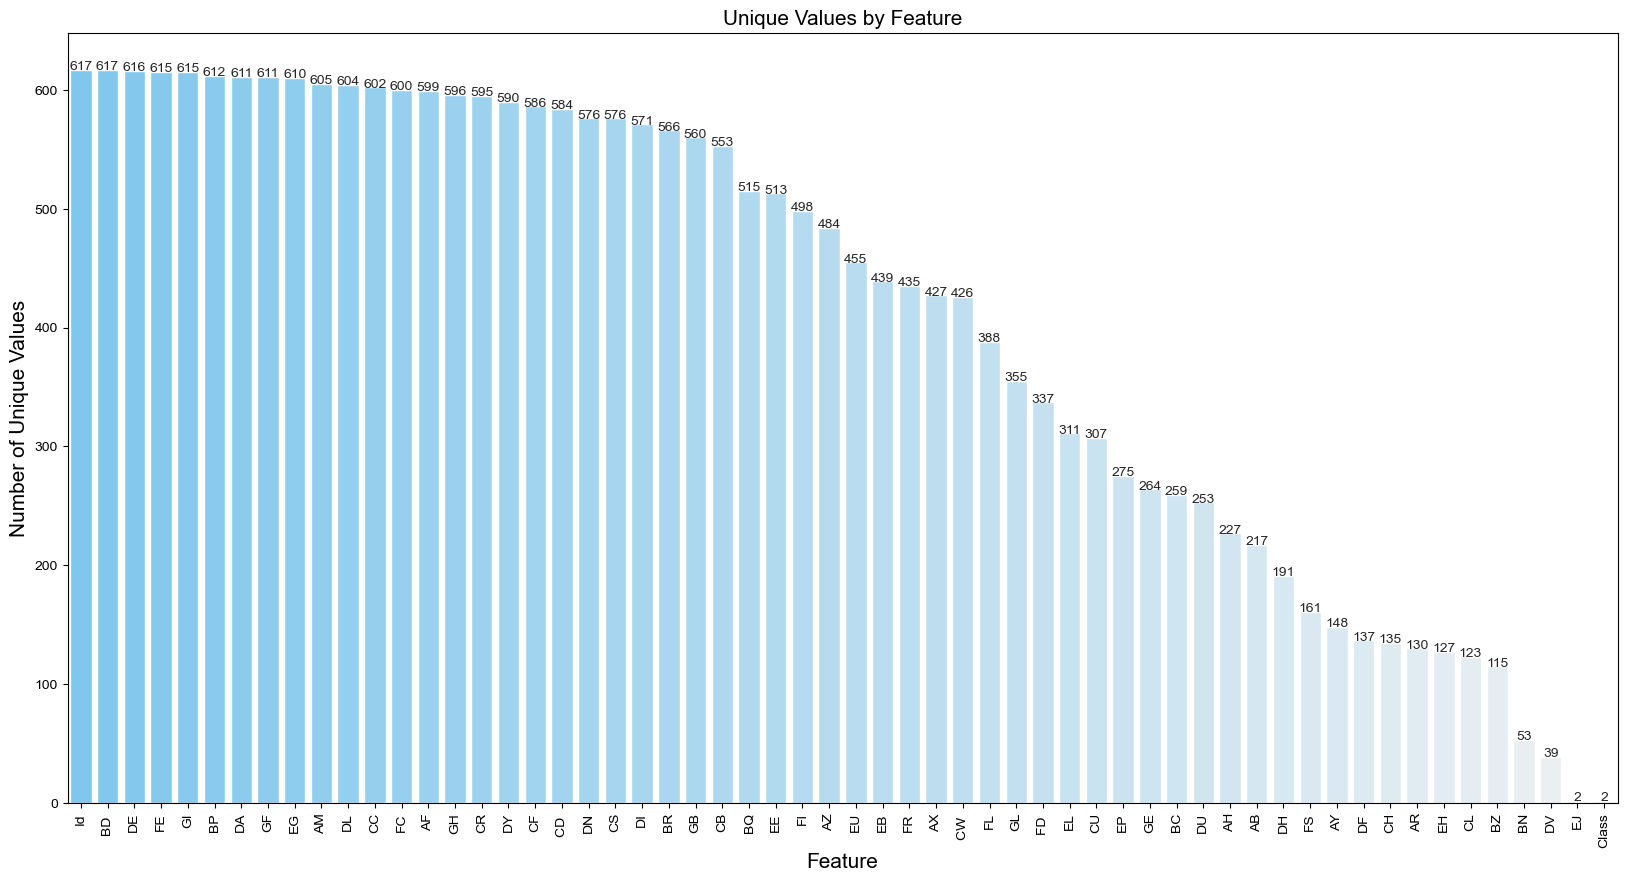

In [11]:
# Count unique values in each feature

# Initialize a dictionary to store feature names and their corresponding unique value counts
data = {
    "Feature": [],
    "Counts": []
}

# Loop through each column in the dataset
for feature in train.columns:
    if feature != "null_count":  # Exclude the "null_count" column from analysis
        data["Feature"].append(feature)  # Add the feature name to the dictionary
        data["Counts"].append(train[feature].nunique())  # Count unique values for the feature and add to the dictionary

# Create a plot to visualize the unique value counts
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(20, 10))  # Set up a single subplot with specified dimensions

# Configure the visual style of the plot
sns.set_style('darkgrid')  # Set the background style to 'darkgrid'
cmap = sns.color_palette(sns.light_palette("#6ecdff", n_colors=len(train.columns), reverse=True))  # Define a color palette
sns.set_palette(cmap)  # Apply the color palette

# Convert the dictionary to a DataFrame for easier plotting
counts = pd.DataFrame(data)

# Create a bar plot showing the number of unique values for each feature
_ = sns.barplot(
    x=counts.Feature, 
    y=counts.Counts, 
    ax=ax, 
    order=counts.sort_values('Counts', ascending=False).Feature  # Sort features by unique value count in descending order
)

# Add annotations to each bar to display the unique value count
for p in ax.patches:
    ax.text(
        x=p.get_x() + (p.get_width() / 2),  # Center the text horizontally on the bar
        y=p.get_height(),  # Position the text above the bar
        s="{:,d}".format(round(p.get_height())),  # Format the value as an integer with commas
        ha="center"  # Center-align the text
    )

# Set titles and axis labels with appropriate font sizes
_ = ax.set_title("Unique Values by Feature", fontsize=15)
_ = ax.set_ylabel("Number of Unique Values", fontsize=15)
_ = ax.set_xlabel("Feature", fontsize=15)

# Rotate x-axis labels for better readability
for label in ax.get_xticklabels():
    label.set_rotation(90)

The `train` dataset contains 617 unique Id values.

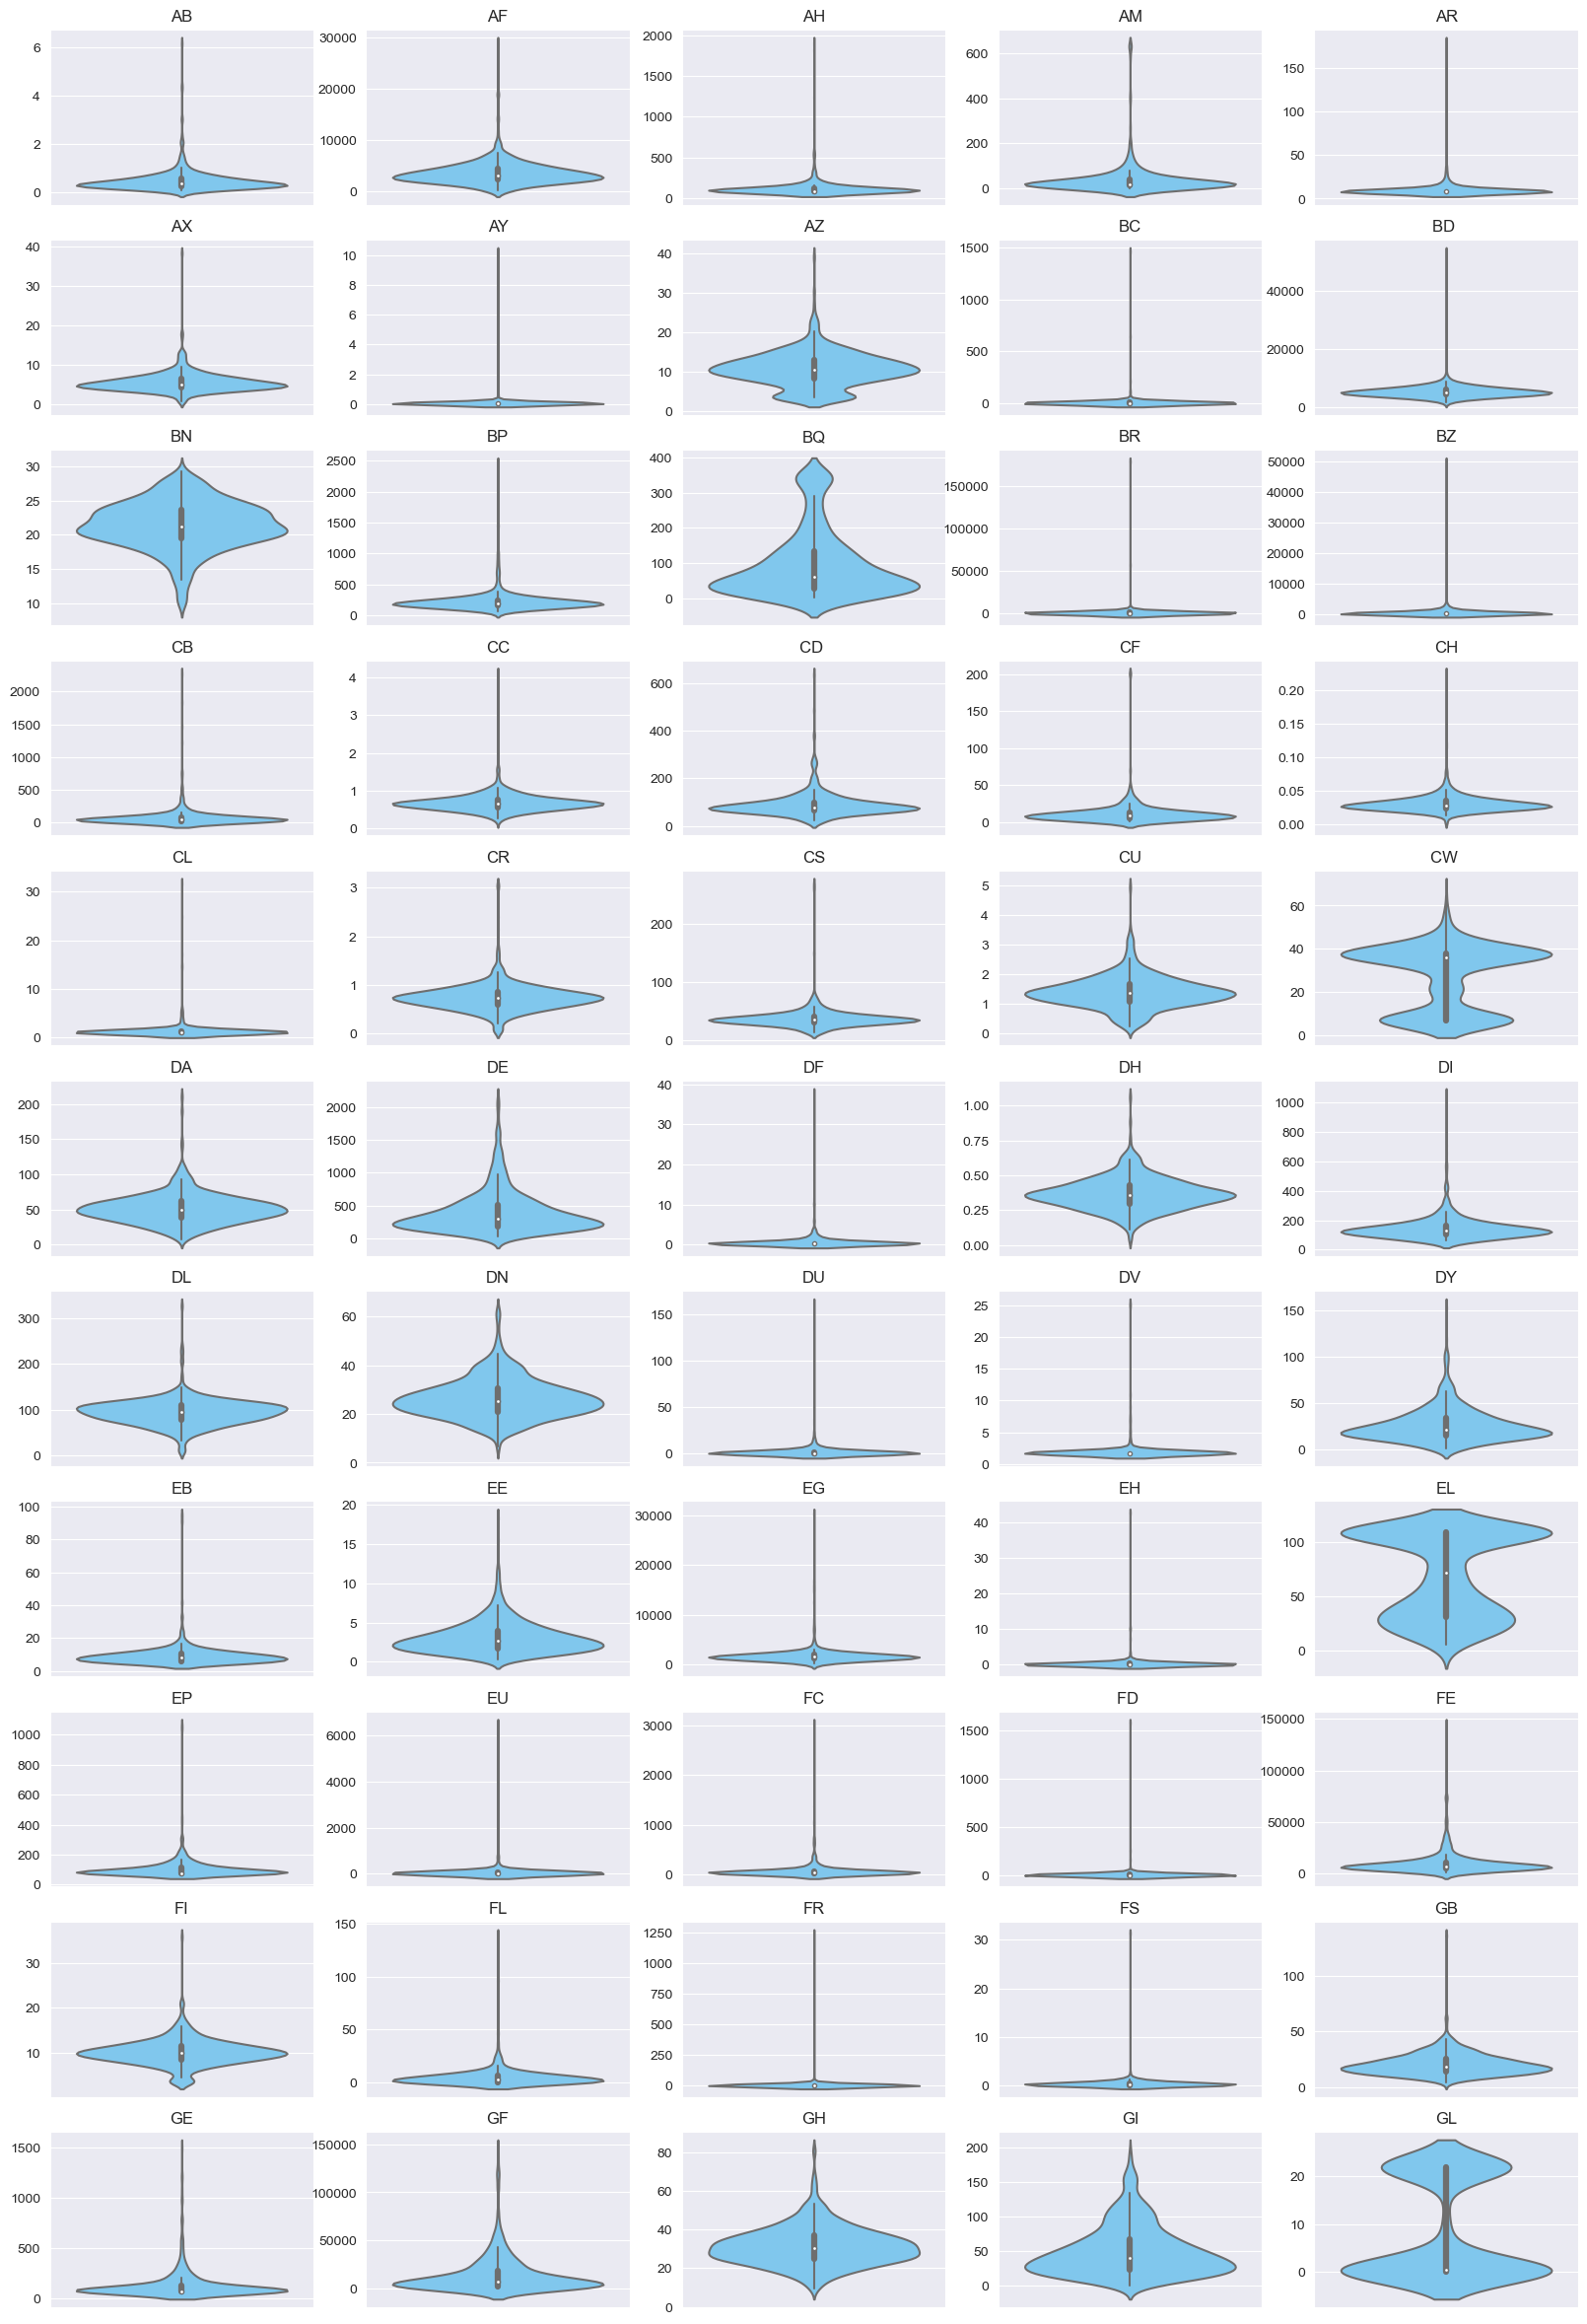

In [13]:
# Violin Plot for Feature Distributions

# List of features to visualize
features = [
    'AB', 'AF', 'AH', 'AM', 'AR', 'AX', 'AY', 'AZ', 'BC', 'BD ', 'BN',
    'BP', 'BQ', 'BR', 'BZ', 'CB', 'CC', 'CD ', 'CF', 'CH', 'CL', 'CR', 'CS',
    'CU', 'CW ', 'DA', 'DE', 'DF', 'DH', 'DI', 'DL', 'DN', 'DU', 'DV', 'DY',
    'EB', 'EE', 'EG', 'EH', 'EL', 'EP', 'EU', 'FC', 'FD ', 'FE', 'FI',
    'FL', 'FR', 'FS', 'GB', 'GE', 'GF', 'GH', 'GI', 'GL'
]

# Create a grid of subplots for the violin plots
fig, axs = plt.subplots(nrows=11, ncols=5, figsize=(20, 30))  # 11 rows and 5 columns
axs = axs.flatten()  # Flatten the 2D array of axes into a 1D array for easy iteration

sns.set_style('darkgrid')  # Set the plot style to 'darkgrid'

# Plot each feature's distribution as a violin plot
axis_counter = 0
for feature in features:
    ax = axs[axis_counter]  # Get the current axis
    _ = sns.violinplot(y=train[feature], ax=ax)  # Create the violin plot for the feature
    _ = ax.set_title("{}".format(feature))  # Set the title of the subplot to the feature name
    _ = ax.set_ylabel("")  # Remove y-axis label for a cleaner look
    _ = ax.set_xlabel("")  # Remove x-axis label for a cleaner look
    axis_counter += 1  # Move to the next axis

# Notes:
# 1. A violin plot shows the distribution of the data, including its density and potential outliers.
# 2. Each subplot corresponds to one feature from the `features` list.
# 3. Adjust `figsize`, `nrows`, and `ncols` as needed based on the number of features and the desired layout.


The violin plot matrix illustrates the distribution of individual features in the dataset, including percentiles, medians, and the density of data points. Features such as `GH` and `GI` exhibit distributions concentrated near zero with long tails, which may indicate potential outliers. However, given the medical context and the lack of specific knowledge about the meaning of these values, no outlier treatment was performed. Additionally, the violin plots reveal significant distribution differences among certain features, suggesting the potential need for dimensionality reduction in subsequent analyses.

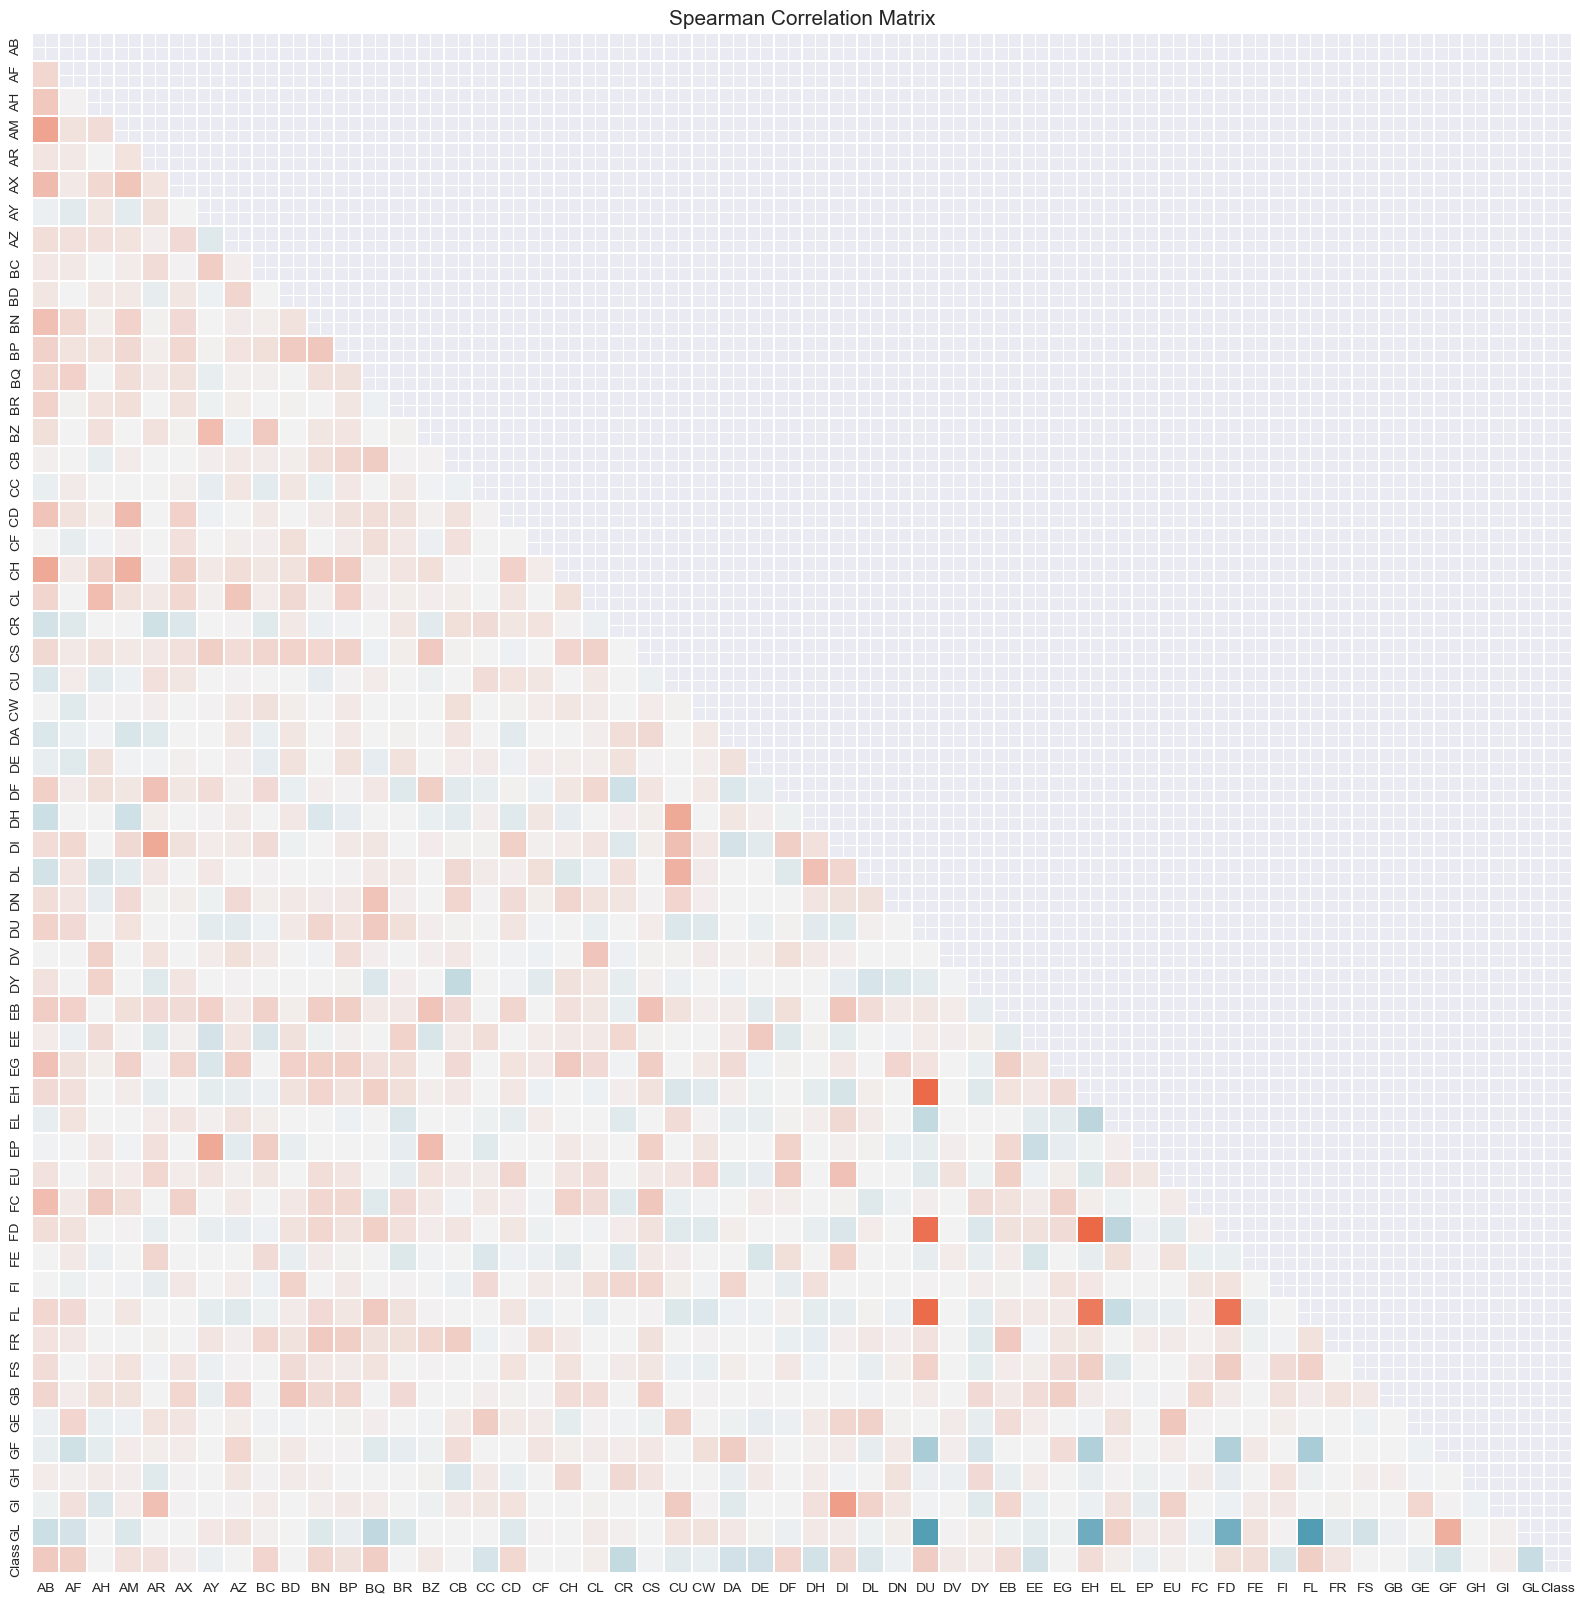

In [14]:
# Heatmap of the correlation matrix for the `train` dataset

# List of features to include in the correlation matrix
features = [
    'AB', 'AF', 'AH', 'AM', 'AR', 'AX', 'AY', 'AZ', 'BC', 'BD ', 'BN',
    'BP', 'BQ', 'BR', 'BZ', 'CB', 'CC', 'CD ', 'CF', 'CH', 'CL', 'CR', 'CS',
    'CU', 'CW ', 'DA', 'DE', 'DF', 'DH', 'DI', 'DL', 'DN', 'DU', 'DV', 'DY',
    'EB', 'EE', 'EG', 'EH', 'EJ', 'EL', 'EP', 'EU', 'FC', 'FD ', 'FE', 'FI',
    'FL', 'FR', 'FS', 'GB', 'GE', 'GF', 'GH', 'GI', 'GL', 'Class'  # Include target variable `Class`
]

# Compute the Spearman correlation matrix for the selected features
# Spearman correlation is used to measure the monotonic relationship between features
correlation_matrix = train[features].corr(method="spearman")

# Import necessary color normalization
from matplotlib.colors import SymLogNorm

# Create a figure and axis for the heatmap
f, ax = plt.subplots(figsize=(20, 20))

# Generate a heatmap
_ = sns.heatmap(
    correlation_matrix,  # Provide the correlation matrix
    mask=np.triu(np.ones_like(correlation_matrix, dtype=bool)),  # Mask the upper triangle for a cleaner look
    cmap=sns.diverging_palette(220, 20, l=60, sep=10, as_cmap=True),  # Use a diverging color palette
    center=0,  # Set the midpoint of the colormap at 0
    square=True,  # Ensure each cell in the heatmap is square
    linewidths=0.1,  # Add thin lines between cells
    cbar=False,  # Disable the color bar
    ax=ax,  # Specify the axis
    annot=False,  # Do not annotate the heatmap with correlation values
)

# Set the title for the heatmap
_ = ax.set_title("Spearman Correlation Matrix", fontsize=15)


A rectangular heatmap was generated for the `train` dataset, illustrating the Spearman correlation coefficients between the features. Due to the large number of features, the exact correlation values are not displayed. However, the intensity of the colors represents the strength of the correlations. Deep red indicates strong positive correlations, while deep blue signifies strong negative correlations. From the heatmap, it can be observed that no single feature exhibits a strong correlation with the target variable, but certain features show significant correlations with each other.

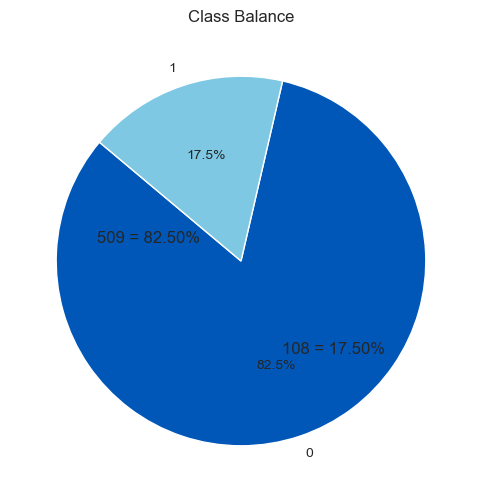

In [15]:
# Calculating the proportion of each class in the 'class' column
class_counts = train['Class'].value_counts()
class_percentages = train['Class'].value_counts(normalize=True) * 100

# Plotting the class distribution as a pie chart
plt.figure(figsize=(8, 6))
plt.pie(class_counts, labels=class_counts.index, autopct='%1.1f%%', startangle=140, colors=['#0057b8', '#7ec8e3'])
plt.title("Class Balance")

# Displaying the class counts and percentages on the chart
for i, (count, percentage) in enumerate(zip(class_counts, class_percentages)):
    plt.text(-0.5 if i == 0 else 0.5, 0.1 if i == 0 else -0.5, f"{count} = {percentage:.2f}%", ha='center', fontsize=12)

# Showing the plot
plt.show()

The dataset exhibits a significant imbalance in feature distributions, which must be addressed during the parameter tuning phase of model training to ensure robust performance. Additionally, undersampling strategies will be considered in the subsequent SVC model to tackle the issue of data imbalance.

# 3. Methodology

Based on the results of the data exploration, the following methods were employed:

- **Unsupervised Learning**: Principal Component Analysis (PCA) and Kernel Principal Component Analysis (KPCA) were used to perform dimensionality reduction on the raw data.
- **Supervised Learning**: Classification models including Decision Tree, Random Forest, LightGBM, and Support Vector Classifier (SVC) were selected to address the classification task.

These methods were chosen to effectively analyze the dataset and optimize the predictive performance of the models.

## 3.1 Unsupervised Learning

### 3.1.1 Principal Component Analysis(PCA)

Principal Component Analysis (PCA) is a widely used unsupervised learning method for dimensionality reduction, which aims to transform high-dimensional data into a lower-dimensional space while retaining most of the variance present in the original data. It achieves this by identifying the directions, called principal components, along which the variance of the data is maximized.


<div style="font-size: 12pt; font-weight: bold; line-height: 1.5;">
1. Mathematical Formulation
</div>

Given a dataset $ X \in \mathbb{R}^{n \times p} $, where $ n $ is the number of observations and $ p $ is the number of features:
1. **Standardization**: The data is centered by subtracting the mean of each feature:
   $$
   X_{\text{centered}} = X - \mu
   $$
   where $ \mu $ is the mean vector of $ X $.

2. **Covariance Matrix**: Compute the covariance matrix of the centered data:
   $$
   \Sigma = \frac{1}{n-1} X_{\text{centered}}^\top X_{\text{centered}}
   $$

3. **Eigen Decomposition**: Perform eigen decomposition on the covariance matrix to obtain eigenvalues ($ \lambda_i $) and eigenvectors ($ v_i $):
   $$
   \Sigma v_i = \lambda_i v_i
   $$

4. **Principal Components**: The eigenvectors corresponding to the largest eigenvalues represent the directions of maximum variance in the data. The data is projected onto these eigenvectors:
   $$
   Z = X_{\text{centered}} V_k
   $$
   where $ V_k $ contains the top $ k $ eigenvectors, and $ Z $ is the transformed data in $ k $-dimensional space.


<div style="font-size: 12pt; font-weight: bold; line-height: 1.5;">
2. Advantages 
</div>

- **Variance Preservation**: PCA ensures that the retained dimensions explain the maximum possible variance in the data.
- **Noise Reduction**: By projecting data into a lower-dimensional space, PCA helps eliminate noise and redundancy.

<div style="font-size: 12pt; font-weight: bold; line-height: 1.5;">
3. Limitations
</div>

- **Linear Assumption**: PCA assumes linear relationships between features, which may not capture complex non-linear patterns.
- **Interpretability**: Principal components are linear combinations of original features and may not have straightforward interpretations in the context of the dataset.

In this study, PCA was applied to the `train` dataset to reduce its dimensionality before feeding the data into supervised learning models. The number of principal components was chosen based on the explained variance ratio, ensuring that the majority of the variance was preserved while minimizing dimensionality.


### 3.1.2 Kernel Principal Component Analysis(KPCA)

Kernel Principal Component Analysis (KPCA) is a non-linear extension of the standard Principal Component Analysis (PCA). It utilizes kernel methods to project data into a higher-dimensional feature space where linear relationships in the transformed space correspond to non-linear relationships in the original space. This makes KPCA particularly useful for datasets with complex structures that cannot be effectively captured by linear PCA.

<div style="font-size: 12pt; font-weight: bold; line-height: 1.5;">
1. Mathematical Formulation
</div>

Given a dataset $X \in \mathbb{R}^{n \times p}$, where $n$ is the number of observations and $p$ is the number of features:

- **Kernel Function**:  
   KPCA uses a kernel function $k(x_i, x_j)$ to compute the similarity between two data points $x_i$ and $x_j$ in the original input space. Common kernel functions include:
   - Linear kernel:  
     $k(x_i, x_j) = x_i^\top x_j$
   - Polynomial kernel (degree $d$):  
     $k(x_i, x_j) = (x_i^\top x_j + c)^d$
   - Radial Basis Function (RBF) kernel:  
     $k(x_i, x_j) = \exp\left(-\frac{\|x_i - x_j\|^2}{2\sigma^2}\right)$

- **Kernel Matrix**:  
   Construct the kernel matrix $K \in \mathbb{R}^{n \times n}$, where each element is defined as:  
   $K_{ij} = k(x_i, x_j)$

- **Centering the Kernel Matrix**:  
   To ensure the data is centered in the feature space, the kernel matrix is centered as follows:  
   $K' = K - 1_n K - K 1_n + 1_n K 1_n$  
   where $1_n$ is an $n \times n$ matrix with all elements equal to $\frac{1}{n}$.

- **Eigen Decomposition**:  
   Perform eigen decomposition on the centered kernel matrix:  
   $K' \alpha = \lambda \alpha$  
   where $\lambda$ are the eigenvalues and $\alpha$ are the corresponding eigenvectors.

- **Projection**:  
   The data is projected into the new feature space using the eigenvectors:  
   $Z = \alpha^\top K$  
   where $Z$ represents the transformed data in the kernel-induced feature space.

<div style="font-size: 12pt; font-weight: bold; line-height: 1.5;">
2. Advantages
</div>

- **Captures Non-Linear Relationships**: KPCA maps data into a higher-dimensional space to capture non-linear patterns that cannot be detected by standard PCA.
- **Flexibility with Kernels**: The choice of kernel functions allows KPCA to adapt to various data structures.
- **Dimensionality Reduction**: Like PCA, KPCA reduces the dimensionality of the data while preserving variance in the transformed feature space.

<div style="font-size: 12pt; font-weight: bold; line-height: 1.5;">
3. Limitations
</div>

- **Computational Complexity**: KPCA requires computation of the kernel matrix, which can be expensive for large datasets.
- **Parameter Tuning**: The performance of KPCA heavily depends on the choice of the kernel function and its parameters, such as $\sigma$ for the RBF kernel.



In this study, KPCA was applied to the `train` dataset as a complementary dimensionality reduction technique alongside PCA. The number of principal components was determined based on the cumulative explained variance, ensuring that the majority of variance was preserved in the reduced feature space.


## 3.2 Supervised Learning

### 3.2.1 Decision Tree

Decision Tree is a supervised learning algorithm widely used for classification and regression tasks. It operates by recursively partitioning the dataset into subsets based on feature values, aiming to maximize the purity of the resulting subsets at each step. The structure of a decision tree is hierarchical, consisting of nodes (decision points) and edges (paths), which makes it intuitive and interpretable.

<div style="font-size: 12pt; font-weight: bold; line-height: 1.5;">
1. Mathematical Formulation
</div>

The key objective of a Decision Tree is to find the feature and split point that maximizes the reduction in impurity at each node. Common impurity measures include:

- **Gini Impurity**:
   $$
   G(t) = 1 - \sum_{i=1}^k p_i^2
   $$
   where $ G(t) $ is the Gini impurity of node $ t $, $ k $ is the number of classes, and $ p_i $ is the proportion of samples in class $ i $ at node $ t $.

- **Entropy**:
   $$
   H(t) = -\sum_{i=1}^k p_i \log_2 p_i
   $$
   where $ H(t) $ is the entropy of node $ t $, and $ p_i $ represents the proportion of samples in class $ i $ at node $ t $.

The reduction in impurity (e.g., Information Gain for entropy) is calculated as:
$$
\Delta H = H(t) - \left[ \frac{N_L}{N} H(t_L) + \frac{N_R}{N} H(t_R) \right]
$$
where:
- $ t_L $ and $ t_R $ are the left and right child nodes.
- $ N_L $, $ N_R $, and $ N $ represent the number of samples in the left child, right child, and parent node, respectively.

The algorithm selects the feature and split point that maximizes $ \Delta H $ (or minimizes impurity).

<div style="font-size: 12pt; font-weight: bold; line-height: 1.5;">
2. Advantages
</div>

- **Interpretability**: Decision Trees are easy to understand and visualize.
- **Versatility**: They handle both categorical and numerical data effectively.
- **Non-parametric**: No assumptions are made about the underlying data distribution.

<div style="font-size: 12pt; font-weight: bold; line-height: 1.5;">
3. Limitations
</div>

- **Overfitting**: Decision Trees are prone to overfitting, especially on small or noisy datasets.
- **Instability**: Small changes in the data can result in significant changes in the tree structure.
- **Bias Towards Features with More Levels**: Decision Trees may favor features with more split points.



In this study, a Decision Tree was used as one of the supervised learning models to classify the target variable.


### 3.2.2 Random Forest

Random Forest is an ensemble learning method that combines multiple Decision Trees to improve classification or regression performance. It builds each tree using a random subset of the data and features, and aggregates their predictions to enhance accuracy and reduce overfitting.

<div style="font-size: 12pt; font-weight: bold; line-height: 1.5;">
1. Mathematical Formulation
</div>

- **Bootstrap Sampling**: For a dataset with $n$ samples, Random Forest generates $m$ decision trees, each trained on a random subset of the data (with replacement). Let the subset for tree $j$ be denoted as $D_j$.
  
- **Split Selection**: At each split, only a random subset of features (of size $k$) is considered to find the optimal split.

- **Prediction Aggregation**:
  - For classification:
    $$
    \hat{y} = \text{mode}(y_1, y_2, \dots, y_m)
    $$
    where $y_j$ is the prediction of the $j$-th tree.
  - For regression:
    $$
    \hat{y} = \frac{1}{m} \sum_{j=1}^m y_j
    $$

<div style="font-size: 12pt; font-weight: bold; line-height: 1.5;">
2. Advantages and Limitations
</div>

- **Advantages**:
  - Robust to overfitting due to averaging.
  - Handles high-dimensional data effectively.
  - Works well with both classification and regression tasks.

- **Limitations**:
  - Computationally expensive for large datasets.
  - Less interpretable compared to individual Decision Trees.


In this study, Random Forest was employed for classification tasks. 


### 3.2.3 LightGBM

LightGBM (Light Gradient Boosting Machine) is a gradient-boosting framework designed to be efficient and scalable for large datasets. It uses a histogram-based approach to speed up training and reduces memory usage.

<div style="font-size: 12pt; font-weight: bold; line-height: 1.5;">
1. Mathematical Formulation
</div>

- **Objective Function**:
  $$
  \mathcal{L} = \sum_{i=1}^n l(y_i, f(x_i)) + \sum_{j=1}^T \Omega(T_j)
  $$
  where:
  - $l(y_i, f(x_i))$ is the loss function (e.g., cross-entropy for classification).
  - $\Omega(T_j)$ is the regularization term for tree $T_j$.
  
- **Gradient Boosting**:
  LightGBM uses gradient-based optimization to minimize the loss:
  $$
  g_i = \frac{\partial l(y_i, f(x_i))}{\partial f(x_i)}
  $$
  $$
  h_i = \frac{\partial^2 l(y_i, f(x_i))}{\partial f(x_i)^2}
  $$
  where $g_i$ and $h_i$ are the first and second-order gradients, respectively.

- **Leaf-Wise Growth**:
  Instead of level-wise growth, LightGBM grows trees leaf-wise, focusing on leaves with the largest loss reduction.

<div style="font-size: 12pt; font-weight: bold; line-height: 1.5;">
2. Advantages and Limitations
</div>

- **Advantages**:
  - Faster training due to histogram-based splitting.
  - Handles large datasets with high accuracy.
  - Supports categorical features directly.

- **Limitations**:
  - Prone to overfitting for small datasets.
  - Requires careful tuning of hyperparameters.


In this study, LightGBM was used for its efficiency in handling high-dimensional data. Hyperparameters such as the number of leaves, learning rate, and maximum depth were optimized.


### 3.2.4 Support Vector Classifier(SVC)

Support Vector Classifier (SVC) is a supervised learning algorithm that constructs a hyperplane to separate data points into different classes with maximum margin. It is effective for both linear and non-linear classification.

<div style="font-size: 12pt; font-weight: bold; line-height: 1.5;">
1. Mathematical Formulation
</div>

- **Objective Function**:
  $$
  \min \frac{1}{2} \|w\|^2 + C \sum_{i=1}^n \xi_i
  $$
  subject to:
  $$
  y_i (w^\top x_i + b) \geq 1 - \xi_i, \quad \xi_i \geq 0
  $$
  where:
  - $w$ is the weight vector.
  - $b$ is the bias term.
  - $\xi_i$ are slack variables to allow misclassification.
  - $C$ controls the trade-off between maximizing margin and minimizing misclassification.

- **Kernel Trick**:
  To handle non-linear data, SVC uses kernel functions to project data into a higher-dimensional space. Common kernels include:
  - Linear kernel: $k(x_i, x_j) = x_i^\top x_j$
  - Polynomial kernel: $k(x_i, x_j) = (x_i^\top x_j + c)^d$
  - RBF kernel: $k(x_i, x_j) = \exp\left(-\frac{\|x_i - x_j\|^2}{2\sigma^2}\right)$

<div style="font-size: 12pt; font-weight: bold; line-height: 1.5;">
2. Advantages and Limitations
</div>

- **Advantages**:
  - Effective for high-dimensional data.
  - Supports non-linear classification with kernel functions.
  - Robust to overfitting for small datasets.

- **Limitations**:
  - Computationally expensive for large datasets.
  - Requires careful selection of kernel functions and hyperparameters.

In this study, SVC was used for its ability to handle complex non-linear patterns.

## 3.3 Evaluation Metrics

Since the prediction task in this study is a binary classification problem, and the dataset exhibits variable imbalance as analyzed earlier, relying on simple metrics such as accuracy or F1-score could lead to misleading conclusions. To better evaluate model performance on imbalanced datasets, the study utilized the **balanced log loss** metric provided by the competition. This metric accounts for the imbalance between the two classes by assigning appropriate weights and adjusts for differences in the number of samples between the classes. The formula is defined as:

$$
\text{balanced log loss} = \frac{-\frac{1}{N_0} \sum_{i=1}^{N_0} y_{0i} \log p_{0i} - \frac{1}{N_1} \sum_{i=1}^{N_1} y_{1i} \log p_{1i}}{2}
$$

where:
- $N_0$ and $N_1$ represent the number of samples in class 0 and class 1, respectively.
- $y_{0i}$ and $y_{1i}$ are the true labels for class 0 and class 1.
- $p_{0i}$ and $p_{1i}$ are the predicted probabilities for class 0 and class 1.

By using the balanced log loss metric, the evaluation process ensures fair consideration of both classes and provides a more reliable measure of model performance on imbalanced data.


# 4. Experiments and Results

In this section, the following steps were performed:

1. **Preprocessing**: The `train` dataset was processed by converting categorical variables and handling missing values.

2. **Dimensionality Reduction**: Principal Component Analysis (PCA) and Kernel Principal Component Analysis (KPCA) were applied to reduce the dimensionality of the dataset. The performance of models trained on the original dataset was compared to those trained on the reduced-dimension datasets.

3. **Train-Test Split**: The dataset was split into training and testing sets in a 4:1 ratio. Models were evaluated based on their balanced log loss and run time to compare performance.

4. **Hyperparameter Optimization with Optuna**:
   - After the preliminary comparison, the better-performing models were selected for hyperparameter optimization using **Optuna**.
   - Optuna uses the `optuna.samplers.TPESampler` by default, a Bayesian optimization method that selects the best parameter combination by repeatedly evaluating the objective function with different parameter values. 
   - Compared to traditional methods like grid search and random search, Optuna offers advantages such as distributed parallel optimization, compatibility with multiple machine learning frameworks, and the ability to prune unpromising trials, making it more efficient in exploring the hyperparameter space and accelerating model tuning.
   - Additionally, Optuna provides an `optuna-dashboard` for tracking each trial's learning process.

5. **Model Evaluation**: The optimized models were compared in terms of prediction accuracy and runtime. The best-performing model was selected for final predictions and variable interpretation.

The dataset splitting method is illustrated below:

<div style="text-align: center;">
    <img src="./tmp_results/split.png" alt="Dataset Splitting Method" style="width:50%;"/>
</div>

<div style="text-align: center; font-size: 10pt;">
Figure 2: Dataset Splitting Method
</div>


## 4.1 Data Cleaning

In [16]:
#Qualitative variable transformation
train['EJ'] = train['EJ'].replace({'A': 0, 'B': 1})

Considering that outliers in the data were retained during the preprocessing steps, the study opted to handle missing values by imputing with the median. This method is robust to the influence of outliers, ensuring more stable and reliable results.

In [17]:
#The median is used to fill in the missing values
train.fillna(train.median(),inplace=True)
train = train.drop(['Id'], axis=True)
train.to_csv(read_path + 'train_20241109.csv', index=False)

## 4.2 Data Processing

In [11]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import KernelPCA
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, accuracy_score, confusion_matrix, ConfusionMatrixDisplay, RocCurveDisplay, make_scorer
from sklearn.preprocessing import LabelEncoder,StandardScaler
from sklearn.model_selection import KFold, StratifiedKFold, train_test_split, GridSearchCV

### 4.2.1 PCA

In [13]:
train = pd.read_csv(read_path + 'train_20241109.csv')
train.head()

,AB,AF,AH,AM,AR,AX,AY,AZ,BC,BD,...,FL,FR,FS,GB,GE,GF,GH,GI,GL,Class
0,0.209377,3109.03329,85.200147,22.394407,8.138688,0.699861,0.025578,9.812214,5.555634,4126.58731,...,7.298162,1.73855,0.094822,11.339138,72.611063,2003.810319,22.136229,69.834944,0.120343,1
1,0.145282,978.76416,85.200147,36.968889,8.138688,3.632190,0.025578,13.517790,1.229900,5496.92824,...,0.173229,0.49706,0.568932,9.292698,72.611063,27981.562750,29.135430,32.131996,21.978000,0
2,0.470030,2635.10654,85.200147,32.360553,8.138688,6.732840,0.025578,12.824570,1.229900,5135.78024,...,7.709560,0.97556,1.198821,37.077772,88.609437,13676.957810,28.022851,35.192676,0.196941,0
3,0.252107,3819.65177,120.201618,77.112203,8.138688,3.685344,0.025578,11.053708,1.229900,4169.67738,...,6.122162,0.49706,0.284466,18.529584,82.416803,2094.262452,39.948656,90.493248,0.155829,0
4,0.380297,3733.04844,85.200147,14.103738,8.138688,3.942255,0.054810,3.396778,102.151980,5728.73412,...,8.153058,48.50134,0.121914,16.408728,146.109943,8524.370502,45.381316,36.262628,0.096614,1


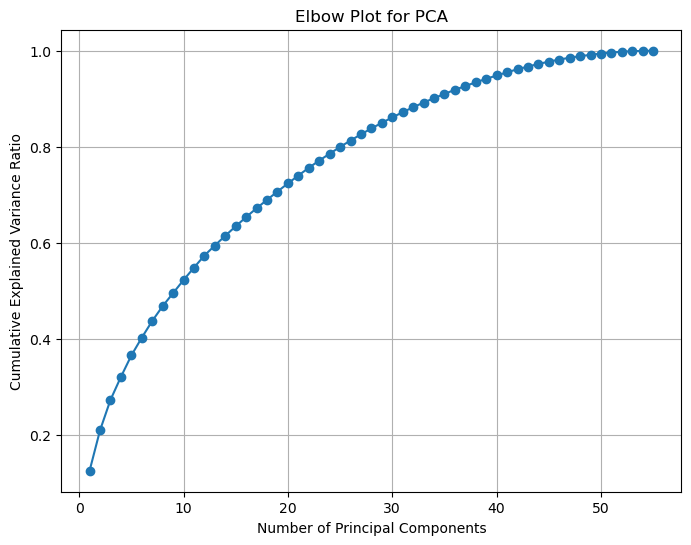

In [14]:
# Dropping non-feature columns (e.g., 'Class', 'EJ')
# Keeping only the numeric feature columns (AB-GL)
features = train.drop(columns=[ 'Class', 'EJ'])

# Standardizing the features for PCA
scaler = StandardScaler()
scaled_features = scaler.fit_transform(features)

# Applying PCA with a large number of components to analyze explained variance
pca = PCA(n_components=len(features.columns))
pca.fit(scaled_features)

# Calculating the cumulative explained variance ratio
explained_variance_ratio = pca.explained_variance_ratio_.cumsum()

# Plotting the explained variance ratio to find the "elbow"
plt.figure(figsize=(8, 6))
plt.plot(range(1, len(explained_variance_ratio) + 1), explained_variance_ratio, marker='o', linestyle='-')
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Explained Variance Ratio')
plt.title('Elbow Plot for PCA')
plt.grid(True)
plt.show()

In [22]:
# Finding the number of components that explain at least 90% of the variance
num_components_90 = next(i for i, cumulative_variance in enumerate(explained_variance_ratio, start=1) if cumulative_variance >= 0.90)
print("Number of components required to explain at least 90% of the variance:", num_components_90)

Number of components required to explain at least 90% of the variance: 34


In [15]:
# Applying PCA to reduce dimensionality to 34 principal components
pca = PCA(n_components=34)
principal_components = pca.fit_transform(scaled_features)

# Creating a DataFrame for the 34 principal components
pca_train = pd.DataFrame(data=principal_components, columns=[f'PC{i}' for i in range(1, 35)])

# Adding the 'EJ' column back to the PCA DataFrame
pca_train['EJ'] = train['EJ'].values
pca_train['Class'] = train['Class'].values

# Displaying the resulting DataFrame
print("DataFrame with 34 principal components and 'EJ' column:")
pca_train.head()
pca_train.to_csv(read_path + 'pca_train_20241109.csv', index=False)

DataFrame with 34 principal components and 'EJ' column:


In [17]:
X_train = train.drop(columns=['Class', 'EJ'])  # Drop the target variable 'Class' and 'EJ' column from the features

# Standardize the features
scaler = StandardScaler()  # Initialize the StandardScaler
X_train_scaled = scaler.fit_transform(X_train)  # Standardize the feature set to have a mean of 0 and standard deviation of 1

# PCA reconstruction
X_pca_reconstructed = pca.inverse_transform(principal_components)

# Calculate PCA reconstruction error (mean squared error)
pca_reconstruction_error = ((X_train_scaled - X_pca_reconstructed) ** 2).mean()
print(f"PCA Reconstruction Error: {pca_reconstruction_error:.4f}")


PCA Reconstruction Error: 0.0988


In [24]:
# Perform PCA with the specified number of components
pca = PCA(n_components=34)
principal_components = pca.fit_transform(scaled_features)

# Retrieve the PCA components matrix (weights of the original features for each principal component)
components = pca.components_

# Create a DataFrame to store the weight information
# Rows represent principal components (PCs), and columns represent the original features
weights_df = pd.DataFrame(
    components, 
    columns=features.columns, 
    index=[f'PC{i}' for i in range(1, 35)]  # Name principal components as PC1, PC2, ..., PC34
)

# Display the weights of original features in each principal component
print("Weights of original features for each principal component:")
weights_df


原始特征在每个主成分上的权重:


,AB,AF,AH,AM,AR,AX,AY,AZ,BC,BD,BN,BP,BQ,BR,BZ,CB,CC,CD,CF,CH,CL,CR,CS,CU,CW,DA,DE,DF,DH,DI,DL,DN,DU,DV,DY,EB,EE,EG,EH,EL,EP,EU,FC,FD,FE,FI,FL,FR,FS,GB,GE,GF,GH,GI,GL
PC1,0.170656,0.072807,0.322136,0.111024,0.315366,0.097040,0.061667,0.090772,0.140985,0.116085,0.069947,0.161415,0.109141,0.008391,0.171067,0.030596,0.077017,0.069967,0.097271,0.296800,0.284061,-0.032368,0.292873,0.064806,0.041577,0.109227,0.053848,0.099674,0.053992,0.134553,0.003349,0.048480,0.016453,0.298985,-0.016446,0.315732,0.075856,0.042538,0.017695,-0.018375,0.277052,0.010650,0.056769,0.020109,0.002566,0.041026,0.030215,-0.006054,0.023059,0.095880,0.028171,0.011870,0.006837,0.017563,0.011318
PC2,0.273598,0.170791,-0.072953,0.252067,-0.164721,0.177791,0.070818,0.073300,0.274259,0.272324,0.112351,0.125969,0.119981,0.040485,0.256850,0.013913,0.200991,0.147215,0.236531,-0.043569,-0.200007,0.020217,-0.161553,0.024811,-0.059854,-0.196620,-0.047822,0.033130,-0.132272,0.121079,-0.000514,0.109511,0.087093,-0.221298,-0.004978,-0.089067,-0.050369,0.037896,0.089533,0.055484,-0.211077,0.003649,0.055084,0.082886,0.041499,0.035241,0.099701,0.002023,0.020401,0.214642,0.042600,-0.031797,0.135115,0.065358,-0.047894
PC3,0.033164,0.119137,-0.053247,0.005339,0.040585,-0.022099,-0.061867,-0.024992,-0.186016,-0.176907,0.072688,0.018114,0.132774,-0.020259,-0.171281,0.052499,-0.151520,0.037021,-0.125126,0.042927,0.011991,-0.006335,0.017659,-0.033737,-0.012850,-0.015704,-0.053726,0.062156,-0.047944,0.054846,0.003741,0.080221,0.434574,0.022059,-0.038878,0.036330,0.056818,0.008608,0.444056,-0.016983,-0.010383,0.001187,-0.024959,0.432087,0.014267,-0.024239,0.383674,0.006829,0.012383,-0.097978,-0.002980,-0.109461,-0.038048,0.064420,-0.188330
PC4,-0.009241,0.208495,-0.114938,-0.001203,0.021004,0.137720,0.012074,0.122790,-0.194033,-0.151777,-0.003303,0.082684,0.124095,-0.020730,-0.189930,0.066008,-0.045888,0.093630,-0.073659,-0.017914,-0.002713,-0.013728,-0.036935,0.307312,0.036405,-0.063271,-0.113666,-0.004447,0.230413,0.307578,0.260290,0.236833,-0.119242,-0.010117,-0.113718,0.040035,-0.092810,0.033297,-0.109912,0.187163,-0.052619,0.203501,-0.034545,-0.100664,0.068904,0.027719,-0.099775,-0.029853,0.038698,-0.107071,0.271589,0.053858,0.012863,0.343600,0.130297
PC5,0.282276,0.125820,-0.024923,0.175246,0.027977,0.181096,-0.133052,0.054686,-0.218782,-0.233783,0.120255,0.094280,0.022079,0.058687,-0.205516,0.041810,-0.176128,0.195470,-0.129080,0.170284,-0.038213,-0.024912,0.022136,-0.280704,-0.069133,-0.143446,-0.068558,0.179595,-0.232567,0.104265,-0.252995,0.001105,-0.187628,-0.038089,0.068630,-0.017971,0.006410,0.102669,-0.207410,-0.075612,-0.025608,-0.097269,0.188728,-0.210490,-0.000693,-0.153195,-0.025929,0.027269,-0.010949,-0.049565,-0.149180,0.022310,-0.021862,-0.092562,-0.085213
PC6,0.006930,0.060443,-0.035261,-0.152992,-0.124452,0.168402,0.063536,0.166436,-0.128280,0.035697,-0.016373,0.114756,0.107826,-0.053156,-0.130399,0.068469,0.013912,0.149139,-0.029258,0.084348,-0.006920,0.320202,0.020709,0.079820,0.052585,0.202278,0.191664,-0.194064,0.160911,-0.164159,0.088815,0.258642,-0.009281,-0.019402,0.043530,-0.067293,0.227558,0.105264,-0.011953,-0.186421,-0.081615,-0.195193,0.078543,-0.016126,-0.226649,0.284798,-0.059646,-0.059215,0.049458,0.043918,-0.169945,0.021771,0.272941,-0.135317,-0.146116
PC7,0.002554,-0.055273,-0.052776,-0.072775,-0.053153,0.127901,0.044115,0.310878,-0.067046,0.030174,0.087175,0.020728,-0.151082,-0.025109,-0.051344,0.028705,-0.095426,-0.157339,-0.016904,0.031558,-0.035233,-0.161784,0.083027,-0.084643,0.166459,0.126672,0.016849,0.004001,-0.045666,-0.029159,-0.165582,0.051004,0.122408,-0.054843,0.183002,-0.026627,-0.072306,0.053247,0.166769,0.267490,-0.008597,-0.030521,0.207537,0.182065,0.066880,0.036320,-0.088657,-0.036411,-0.045396,0.131693,-0.024369,0.455867,0.077205,-0.031388,0.436494
PC8,0.026614,-0.160273,0.058475,-0.051493,-0.075230,-0.010429,-0.340261,-0.052611,0.069371,-0.121712,0.016201,-0.028838,0.009358,-0.000615,0.087740,0.381560,0.085604,0.196519,0.16790

### 4.2.2 KPCA

In [34]:
# Due to runtime and resource requirements, this section was executed on a cloud platform.
# The results were saved for subsequent use.
# Choose appropriate hyperparameter for KPCA

# Separate features and labels
X = train.drop(columns=['Class', 'EJ'])  # Drop the target variable and other unnecessary columns
y = train['Class']  # Extract the target variable

# Standardize the features
scaler = StandardScaler()  # StandardScaler ensures features have a mean of 0 and standard deviation of 1
X_scaled = scaler.fit_transform(X)

# Build a Pipeline and define the parameter grid for Kernel PCA
pipeline = Pipeline([
    ('kpca', KernelPCA(kernel='rbf')),  # Add Kernel PCA step with an initial RBF kernel
    ('clf', RandomForestClassifier(random_state=0))  # Add a Random Forest Classifier as the second step
])

# Define the parameter grid for grid search, including kernels and dimensionality reduction options
param_grid = {
    'kpca__kernel': ['rbf', 'poly', 'sigmoid'],  # Test different kernel functions
    'kpca__n_components': [5, 10, 20, 30],  # Specify the number of components for dimensionality reduction
    'kpca__gamma': [0.01, 0.1, 1, 10]  # Gamma is relevant for the RBF and sigmoid kernels
}

# Set up GridSearchCV
grid_search = GridSearchCV(
    estimator=pipeline,  # Pipeline to optimize
    param_grid=param_grid,  # Parameter grid for tuning
    scoring=make_scorer(accuracy_score),  # Use accuracy as the evaluation metric
    cv=5,  # Perform 5-fold cross-validation
    n_jobs=-1  # Use all available CPU cores for parallel processing
)

# Run grid search to find the best parameters
grid_search.fit(X_scaled, y)

# Retrieve the best parameters found by grid search
best_params = grid_search.best_params_
print("Best kernel and parameter combination:", best_params)

# Apply Kernel PCA with the best parameters
best_kpca = KernelPCA(
    kernel=best_params['kpca__kernel'],  # Best kernel identified during grid search
    n_components=best_params['kpca__n_components'],  # Best number of components
    gamma=best_params.get('kpca__gamma', None)  # Gamma parameter if applicable (only for RBF and sigmoid)
)
X_kpca = best_kpca.fit_transform(X_scaled)  # Perform dimensionality reduction on the scaled features

# Print the shape of the reduced data
print("Shape of the data after dimensionality reduction:", X_kpca.shape)


In [ ]:
# Load the train dataset
train = pd.read_csv(read_path + 'train_20241109.csv')

# Separate features and labels
EJ_train = train['EJ']  # Extract the 'EJ' column to be re-added later
X_train = train.drop(columns=['Class', 'EJ'])  # Drop the target variable 'Class' and 'EJ' column from the features
y_train = train['Class']  # Extract the target variable 'Class'

# Standardize the features
scaler = StandardScaler()  # Initialize the StandardScaler
X_train_scaled = scaler.fit_transform(X_train)  # Standardize the feature set to have a mean of 0 and standard deviation of 1

# Perform Kernel PCA with the best parameters
best_kpca = KernelPCA(
    kernel='poly',       # Polynomial kernel selected based on previous tuning
    n_components=20,     # Reduce to 20 dimensions
    gamma=0.01           # Gamma value for the polynomial kernel
)

# Apply dimensionality reduction to the train dataset
X_train_kpca = best_kpca.fit_transform(X_train_scaled)

# Convert the reduced data to a DataFrame and add the label and 'EJ' columns
train_kpca = pd.DataFrame(
    X_train_kpca, 
    columns=[f'PC{i+1}' for i in range(X_train_kpca.shape[1])]  # Name the principal components as PC1, PC2, ..., PC20
)
train_kpca['Class'] = y_train.values  # Add the target variable back to the DataFrame
train_kpca['EJ'] = EJ_train.values  # Add the 'EJ' column back to the DataFrame

# Save the reduced dataset to a CSV file
train_kpca.to_csv(read_path + "train_kpca_20241113.csv", index=False)  # Save the DataFrame without the index


In [20]:
from sklearn.metrics.pairwise import pairwise_kernels
from sklearn.decomposition import KernelPCA

# Initialize and fit KernelPCA
best_kpca = KernelPCA(kernel='poly', n_components=20, gamma=0.01, fit_inverse_transform=True)
X_train_kpca = best_kpca.fit_transform(X_train_scaled)

# Reconstruct data using inverse transform
X_kpca_reconstructed = best_kpca.inverse_transform(X_train_kpca)

# Calculate KPCA reconstruction error (mean squared error)
kpca_reconstruction_error = ((X_train_scaled - X_kpca_reconstructed) ** 2).mean()
print(f"KPCA Reconstruction Error: {kpca_reconstruction_error:.4f}")

KPCA Reconstruction Error: 0.4621


The reconstruction errors provide insights into how well PCA and KPCA retain the original data after dimensionality reduction:

1. **PCA Reconstruction Error: 0.0988**
   - PCA achieves a lower reconstruction error, indicating that it is more effective at preserving the original data's structure in this case.
   - This result suggests that the dataset may have a largely linear structure, which PCA is well-suited to capture.

2. **KPCA Reconstruction Error: 0.4621**
   - KPCA exhibits a higher reconstruction error, which could be due to the choice of kernel (polynomial) and hyperparameters (e.g., gamma). This indicates that KPCA struggles to accurately reconstruct the original data in the reduced feature space.

- **PCA** outperforms KPCA in this scenario, likely because the data structure is predominantly linear.
- Further optimization of KPCA parameters (e.g., kernel type, gamma) or selecting a dataset with non-linear patterns could help KPCA perform better.


## 4.3 Models

In [6]:
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
import lightgbm as lgb
from sklearn.svm import SVC
from sklearn.metrics import log_loss
import csv
from sklearn.model_selection import StratifiedKFold
import optuna
from optuna.samplers import TPESampler
import time
from lightgbm import early_stopping
from sklearn.preprocessing import MinMaxScaler
from imblearn.under_sampling import RandomUnderSampler
import shap
from sklearn.inspection import permutation_importance
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

In [7]:
# Define the balanced logarithmic loss function
def balanced_logarithmic_loss_new(y_pred, y_true):
    N_1 = np.sum(y_true == 1)
    N_0 = np.sum(y_true == 0)
    y_pred = np.maximum(np.minimum(y_pred, 1 - 1e-15), 1e-15)
    loss_numerator = - (1 / N_0) * np.sum((1 - y_true) * np.log(1 - y_pred)) - (1 / N_1) * np.sum(y_true * np.log(y_pred))
    return loss_numerator / 2

### 4.3.1 Preliminary Model Comparison

In [3]:
# Load dataset
train_df = pd.read_csv(read_path+"train_20241109.csv")
y_train = train_df['Class']
x_train = train_df.drop(['Class'], axis=True)
x_train.head()

,AB,AF,AH,AM,AR,AX,AY,AZ,BC,BD,...,FI,FL,FR,FS,GB,GE,GF,GH,GI,GL
0,0.209377,3109.03329,85.200147,22.394407,8.138688,0.699861,0.025578,9.812214,5.555634,4126.58731,...,3.583450,7.298162,1.73855,0.094822,11.339138,72.611063,2003.810319,22.136229,69.834944,0.120343
1,0.145282,978.76416,85.200147,36.968889,8.138688,3.632190,0.025578,13.517790,1.229900,5496.92824,...,10.358927,0.173229,0.49706,0.568932,9.292698,72.611063,27981.562750,29.135430,32.131996,21.978000
2,0.470030,2635.10654,85.200147,32.360553,8.138688,6.732840,0.025578,12.824570,1.229900,5135.78024,...,11.626917,7.709560,0.97556,1.198821,37.077772,88.609437,13676.957810,28.022851,35.192676,0.196941
3,0.252107,3819.65177,120.201618,77.112203,8.138688,3.685344,0.025578,11.053708,1.229900,4169.67738,...,14.852022,6.122162,0.49706,0.284466,18.529584,82.416803,2094.262452,39.948656,90.493248,0.155829
4,0.380297,3733.04844,85.200147,14.103738,8.138688,3.942255,0.054810,3.396778,102.151980,5728.73412,...,13.666727,8.153058,48.50134,0.121914,16.408728,146.109943,8524.370502,45.381316,36.262628,0.096614


In [ ]:
# Due to runtime and resource requirements, this section was executed on a cloud platform.
# The results were saved for subsequent use.
# Preparing to record results
results = []

numeric_columns = x_train.select_dtypes(include=["number"]).columns.difference(["EJ"])

# Repeated train-test splits
for i in range(5):  # Adjust the number of repetitions as needed
    X_train1, X_test1, y_train1, y_test1 = train_test_split(x_train, y_train, test_size=0.2, random_state=i)
    
    # Scaling features 
    # Initialize the scaler
    sc = StandardScaler()  

    # Apply scaling only to numeric columns
    X_train1[numeric_columns] = sc.fit_transform(X_train1[numeric_columns])
    X_test1[numeric_columns] = sc.transform(X_test1[numeric_columns])

    
    # Decision Tree
    dt_clf = DecisionTreeClassifier(class_weight='balanced', random_state=i)
    dt_clf.fit(X_train1, y_train1)
    dt_pred = dt_clf.predict_proba(X_test1)[:, 1]
    dt_loss = balanced_logarithmic_loss_new(dt_pred, y_test1)
    results.append({"Model": "Decision Tree", "Split": i+1, "Balanced Log Loss": dt_loss})

    # Random Forest
    rf_clf = RandomForestClassifier(class_weight='balanced', random_state=i)
    rf_clf.fit(X_train1, y_train1)
    rf_pred = rf_clf.predict_proba(X_test1)[:, 1]
    rf_loss = balanced_logarithmic_loss_new(rf_pred, y_test1)
    results.append({"Model": "Random Forest", "Split": i+1, "Balanced Log Loss": rf_loss})

    # LightGBM
    lgb_clf = lgb.LGBMClassifier(class_weight='balanced', random_state=i)
    lgb_clf.fit(X_train1, y_train1, categorical_feature=['EJ'])
    lgb_pred = lgb_clf.predict_proba(X_test1)[:, 1]
    lgb_loss = balanced_logarithmic_loss_new(lgb_pred, y_test1)
    results.append({"Model": "LightGBM", "Split": i+1, "Balanced Log Loss": lgb_loss})

    # SVC
    svc_clf = SVC(probability=True, class_weight='balanced', random_state=i)
    svc_clf.fit(X_train1, y_train1)
    svc_pred = svc_clf.predict_proba(X_test1)[:, 1]
    svc_loss = balanced_logarithmic_loss_new(svc_pred, y_test1)
    results.append({"Model": "SVC", "Split": i+1, "Balanced Log Loss": svc_loss})

# Convert results to DataFrame and save to CSV
results_df = pd.DataFrame(results)
results_df.to_csv(save_path+"raw_logloss_results_20241112.csv", index=False)


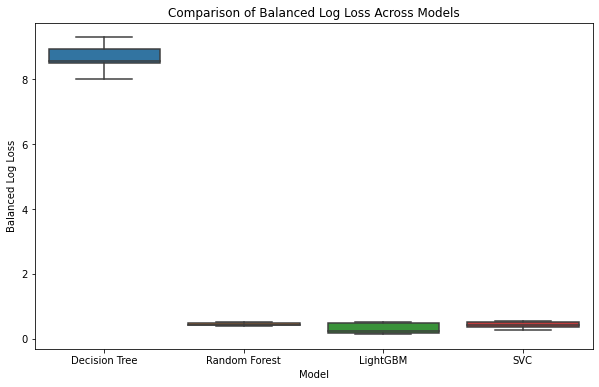

In [8]:
# Load the CSV file containing model comparison results
results_df = pd.read_csv(save_path+"raw_logloss_results_20241112.csv")

# Plot a boxplot to compare the Balanced Log Loss across models
plt.figure(figsize=(10, 6))
sns.boxplot(x='Model', y='Balanced Log Loss', data=results_df)
plt.title('Comparison of Balanced Log Loss Across Models')
plt.xlabel('Model')
plt.ylabel('Balanced Log Loss')
plt.show()

It is evident from the figure that the Decision Tree performs poorly, highlighting that ensemble learning significantly improves accuracy compared to a single learner. Based on this observation, only the Random Forest, LightGBM, and SVC models will be considered for hyperparameter optimization and further comparison in subsequent steps.

### 4.3.2 Model Comparison Based on Optuna

Due to runtime and resource requirements, this section was executed on a cloud platform. The results were saved for subsequent use.

#### 4.3.2.1 Random Forest

In [ ]:
def train_rf_with_optuna(train_dataset_name, n_iterations=10, n_trials=50):
    """
    Train a Random Forest model with hyperparameter optimization using Optuna.
    Perform multiple iterations with cross-validation and log results.

    Args:
        train_dataset_name (str): The name of the training dataset (CSV file).
        n_iterations (int): Number of random splits for train-test splitting.
        n_trials (int): Number of trials for Optuna's hyperparameter search.

    Returns:
        result_rf (DataFrame): DataFrame containing log loss, training time, and best trial value.
    """

    # Load the dataset
    train_df = pd.read_csv(f"{read_path}{train_dataset_name}.csv")

    # Separate features and labels
    y_train = train_df['Class']  # Target variable
    x_train = train_df.drop(['Class'], axis=1)  # Feature variables

    # Perform multiple iterations for train-test splits
    for i in range(n_iterations):
        # Split the data into training and testing sets (80% train, 20% test)
        X_train1, X_test1, y_train1, y_test1 = train_test_split(
            x_train, y_train, test_size=0.2, random_state=i
        )

        # Objective function for Optuna optimization
        def objective(trial):
            # Define the parameter grid for Random Forest
            param_grid = {
                "n_estimators": trial.suggest_int("n_estimators", 100, 1000),  # Number of trees in the forest
                "criterion": trial.suggest_categorical("criterion", ["gini", "entropy"]),  # Split quality measure
                "max_depth": trial.suggest_int("max_depth", 3, 12),  # Maximum depth of each tree
                "min_samples_split": trial.suggest_int("min_samples_split", 2, 10),  # Minimum samples to split a node
                "min_samples_leaf": trial.suggest_int("min_samples_leaf", 1, 5),  # Minimum samples in a leaf node
                "max_features": trial.suggest_categorical("max_features", ["sqrt", "log2"]),  # Features considered at each split
                "class_weight": "balanced",  # Automatically adjust weights for class imbalance
                "random_state": 48,  # Ensures reproducibility
            }

            # Stratified 5-fold cross-validation
            skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

            scores = []

            # Perform 5-fold cross-validation
            for train_index, test_index in skf.split(X_train1, y_train1):
                # Create training and validation sets for this fold
                X_train2, X_test2 = X_train1.iloc[train_index], X_train1.iloc[test_index]
                y_train2, y_test2 = y_train1.iloc[train_index], y_train1.iloc[test_index]

                # Train the Random Forest model with the current set of parameters
                model = RandomForestClassifier(**param_grid)
                model.fit(X_train2, y_train2)

                # Predict probabilities and calculate the balanced log loss
                preds = model.predict_proba(X_test2)[:, 1]
                score = balanced_logarithmic_loss_new(preds, y_test2)
                scores.append(score)

            # Return the average score across the folds
            return np.mean(scores)

        # Initialize an Optuna study to minimize the balanced log loss
        study = optuna.create_study(direction="minimize")
        study.optimize(objective, n_trials=n_trials)  # Perform optimization for the specified number of trials

        # Log the best trial value from the study
        best_trial_value.append(study.best_trial.value)

        # Get the best parameters from Optuna
        best_params = study.best_params

        # Record the start time for training
        start_time = time.time()

        # Train the Random Forest model using the best parameters on the entire training set
        model = RandomForestClassifier(**best_params)
        model.fit(X_train1, y_train1)

        # Calculate the training time
        training_time = time.time() - start_time

        # Predict on the test set and calculate the balanced log loss
        prediction = model.predict_proba(X_test1)[:, 1]
        score_test = balanced_logarithmic_loss_new(prediction, y_test1)

        # Store the results
        log_losses_rf.append(score_test)
        time_rf.append(training_time)

    # Create a DataFrame to store results
    result_rf = pd.DataFrame({
        'log_losses_rf': log_losses_rf,  # Balanced log loss for each iteration
        'time_comsumed_rf': time_rf,  # Time consumed for training in seconds
        'best_value_rf': best_trial_value  # Best trial values from Optuna
    })

    # Save the results to a CSV file
    result_rf.to_csv(f"{save_path}result_rf_{train_dataset_name}.csv", index=False)

    return result_rf


# Datasets to train on
datasets = ['pca_train_20241109', 'train_kpca_20241113', 'train_20241109']

# Train and optimize Random Forest for each dataset
for dataset in datasets:
    result_df = train_rf_with_optuna(
        train_dataset_name=dataset,
        n_iterations=10,  # Number of iterations for train-test splits
        n_trials=50  # Number of trials for Optuna
    )


#### 4.3.2.2 LightGBM

In [ ]:
def train_lightgbm_with_optuna(train_dataset_name, n_iterations=10, n_trials=50):
    """
    Train a LightGBM model with hyperparameter optimization using Optuna.
    Perform multiple iterations with cross-validation and log results.

    Args:
        train_dataset_name (str): Name of the training dataset (CSV file).
        n_iterations (int): Number of random splits for train-test splitting.
        n_trials (int): Number of trials for Optuna's hyperparameter search.

    Returns:
        result_lightGBM (DataFrame): DataFrame containing log loss, training time, and best trial values.
    """

    # Define a global random seed for reproducibility
    RANDOM_STATE = 42

    # Initialize result lists
    log_losses_lightGBM = []  # To store log loss values for each iteration
    time_lightGBM = []  # To store training times for each iteration
    best_trial_value = []  # To store the best trial values from Optuna

    # Load the dataset
    train_df = pd.read_csv(f"{read_path}{train_dataset_name}.csv")

    # Separate features and labels
    y_train = train_df['Class']  # Target variable
    x_train = train_df.drop(['Class'], axis=1)  # Feature variables

    # Perform multiple iterations for train-test splitting
    for i in range(n_iterations):
        # Split the dataset into training and testing sets (80% train, 20% test)
        x_train2, x_test2, y_train2, y_test2 = train_test_split(
            x_train, y_train, test_size=0.2, random_state=i
        )

        # Define the objective function for Optuna
        def objective(trial):
            # Define the hyperparameter search space
            param_grid = {
                "random_state": RANDOM_STATE,  # Fixed random seed for reproducibility
                "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.3),  # Step size for gradient updates
                "num_leaves": trial.suggest_int("num_leaves", 20, 300, step=10),  # Max number of leaves in each tree
                "max_depth": trial.suggest_int("max_depth", 3, 12),  # Maximum depth of the tree
                "reg_alpha": trial.suggest_float("reg_alpha", 1e-8, 10.0, log=True),  # L1 regularization strength
                "reg_lambda": trial.suggest_float("reg_lambda", 1e-8, 10.0, log=True),  # L2 regularization strength
                "bagging_fraction": trial.suggest_float("bagging_fraction", 0.2, 0.95, step=0.05),  # Fraction of data used in bagging
                "bagging_freq": 1,  # Fixed value; perform bagging every iteration
                "feature_fraction": trial.suggest_float("feature_fraction", 0.2, 0.95, step=0.05),  # Fraction of features used for training
                "min_child_samples": trial.suggest_int("min_child_samples", 10, 100, step=5),  # Minimum samples required in a leaf node
                "n_estimators": 10000,  # High value to enable early stopping to determine optimal iterations
            }

            # Initialize Stratified K-Fold cross-validation
            skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)

            scores = []  # To store log loss scores for each fold
            best_iterations = []  # To store the best iteration for each fold

            # Perform 5-fold cross-validation
            for train_index, test_index in skf.split(x_train2, y_train2):
                x_train3, x_valid3 = x_train2.iloc[train_index], x_train2.iloc[test_index]
                y_train3, y_valid3 = y_train2.iloc[train_index], y_train2.iloc[test_index]

                # Train the LightGBM model
                model = lgb.LGBMClassifier(
                    **param_grid,
                    class_weight="balanced",  # Automatically adjust weights for imbalanced classes
                    verbose=-1  # Suppress excessive output
                )
                model.fit(
                    x_train3,
                    y_train3,
                    eval_set=[(x_valid3, y_valid3)],
                    eval_metric='binary_logloss',  # Evaluate binary log loss
                    early_stopping_rounds=300,  # Stop if validation score doesn't improve for 300 rounds
                    verbose=False,
                    callbacks=[LightGBMPruningCallback(trial, 'binary_logloss')],  # Enable Optuna pruning
                    categorical_feature=['EJ']  
                )
                preds = model.predict_proba(x_valid3)[:, 1]  # Predict probabilities for the positive class
                score = balanced_logarithmic_loss_new(preds, y_valid3)  # Calculate balanced log loss
                scores.append(score)
                best_iterations.append(model.best_iteration_)  # Record the best iteration for this fold

            # Return the average log loss across folds and set the best iteration
            func_out = np.mean(scores)
            avg_best_iteration = int(np.mean(best_iterations))
            trial.set_user_attr('avg_best_iteration', avg_best_iteration)

            return func_out

        # Initialize an Optuna study to minimize log loss
        study = optuna.create_study(direction="minimize")
        study.optimize(objective, n_trials=n_trials)

        # Record the best trial value and parameters
        best_trial_value.append(study.best_trial.value)

        print(f"Best value for iteration {i + 1}: {study.best_trial.value}")
        print("Best parameters: ")
        for key, value in study.best_trial.params.items():
            print(f"    {key}: {value}")

        # Retrieve the best parameters and the average best iteration
        avg_best_iteration = study.best_trial.user_attrs['avg_best_iteration']
        best_params = study.best_trial.params.copy()
        best_params['n_estimators'] = avg_best_iteration  # Set n_estimators to the best iteration
        best_params['random_state'] = RANDOM_STATE  # Ensure reproducibility

        # Train the final model with the best parameters
        model = lgb.LGBMClassifier(
            **best_params,
            class_weight="balanced"
        )

        # Final train-test split for evaluation
        x_train_final, x_valid, y_train_final, y_valid = train_test_split(
            x_train2, y_train2, test_size=0.1, random_state=RANDOM_STATE
        )

        # Record training start time
        start_time = time.time()

        # Train the model
        model.fit(
            x_train_final,
            y_train_final,
            eval_set=[(x_valid, y_valid)],
            eval_metric='binary_logloss',
            early_stopping_rounds=300,
            verbose=False,
            categorical_feature=['EJ']  
        )

        # Calculate training time
        training_time = time.time() - start_time

        # Evaluate on the test set
        prediction = model.predict_proba(x_test2)[:, 1]
        score_test = balanced_logarithmic_loss_new(prediction, y_test2)

        # Store results
        log_losses_lightGBM.append(score_test)
        time_lightGBM.append(training_time)

    # Save results to a DataFrame
    result_lightGBM = pd.DataFrame({
        'log_losses': log_losses_lightGBM,
        'time_consumed': time_lightGBM,
        'best_value_lightGBM': best_trial_value
    })
    result_lightGBM.to_csv(f"{save_path}result_lightGBM_{train_dataset_name}.csv", index=False)

    return result_lightGBM


# Train LightGBM on multiple datasets
datasets = ['pca_train_20241109', 'train_kpca_20241113', 'train_20241109']

for dataset in datasets:
    result_df = train_lightgbm_with_optuna(
        train_dataset_name=dataset,
        n_iterations=10,  # Number of iterations
        n_trials=50  # Number of trials for Optuna optimization
    )


#### 4.3.2.3 SVC

In [ ]:
# Initialize result lists for SVM (Support Vector Machine) optimization
log_losses_svm = []  # To store log loss values for each iteration
time_svm = []  # To store training time for each iteration
best_trial_value = []  # To store the best trial values from Optuna

# Number of iterations for train-test splitting
n_iterations = 10

# Perform hyperparameter optimization for SVM using Optuna
for i in range(n_iterations):
    # Split the dataset into training and testing sets (80% train, 20% test)
    x_train2, x_test2, y_train2, y_test2 = train_test_split(
        x_train, y_train, test_size=0.2, random_state=i
    )

    # Define the objective function for Optuna
    def objective(trial):
        # Suggest hyperparameters for SVM
        kernel = trial.suggest_categorical("kernel", ["linear", "rbf", "sigmoid", "poly"])  # Kernel type
        param_grid = {
            "C": trial.suggest_loguniform("C", 1e-3, 1e3),  # Regularization parameter
            "kernel": kernel,  # Kernel type
            "gamma": trial.suggest_categorical("gamma", ["scale", "auto"]),  # Kernel coefficient for 'rbf', 'poly', and 'sigmoid'
            "class_weight": "balanced",  # Handle class imbalance by adjusting class weights
            "probability": True  # Enable probability outputs
        }

        # Add kernel-specific parameters
        if kernel == 'poly':
            param_grid["degree"] = trial.suggest_int("degree", 2, 5)  # Degree of the polynomial kernel
            param_grid["coef0"] = trial.suggest_float("coef0", 0.0, 1.0)  # Independent term in kernel function
        elif kernel == 'sigmoid':
            param_grid["coef0"] = trial.suggest_float("coef0", 0.0, 1.0)  # Independent term in sigmoid kernel
        # No additional parameters are needed for 'linear' and 'rbf' kernels

        # Stratified K-Fold cross-validation
        skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

        scores = []  # To store log loss scores for each fold

        # Perform 5-fold cross-validation
        for train_index, test_index in skf.split(x_train2, y_train2):
            # Create training and validation sets for this fold
            x_train3, x_test3 = x_train2.iloc[train_index], x_train2.iloc[test_index]
            y_train3, y_test3 = y_train2.iloc[train_index], y_train2.iloc[test_index]

            # Scale the data to the range [0, 1]
            scaler = MinMaxScaler()
            scaler.fit(x_train3)
            x_train3 = scaler.transform(x_train3)
            x_test3 = scaler.transform(x_test3)

            # Train the SVM model with the suggested parameters
            model = SVC(**param_grid)
            model.fit(x_train3, y_train3)

            # Predict probabilities and calculate balanced log loss
            preds = model.predict_proba(x_test3)[:, 1]
            score = balanced_logarithmic_loss_new(preds, y_test3)
            scores.append(score)

        # Return the mean log loss across all folds
        return np.mean(scores)

    # Initialize an Optuna study to minimize log loss
    study = optuna.create_study(direction="minimize")
    study.optimize(objective, n_trials=50)  # Perform optimization for 50 trials

    # Record the best trial value and parameters
    best_trial_value.append(study.best_trial.value)

    # Extract the best parameters
    best_params = study.best_params
    best_params["class_weight"] = "balanced"  # Ensure class imbalance handling
    best_params["probability"] = True  # Enable probability outputs

    # Record the start time for training
    start_time = time.time()

    # Scale the data using MinMaxScaler
    scaler = MinMaxScaler()
    scaler.fit(x_train2)
    x_train2_scaled = scaler.transform(x_train2)
    x_test2_scaled = scaler.transform(x_test2)

    # Train the SVM model with the best parameters
    model = SVC(**best_params)
    model.fit(x_train2_scaled, y_train2)

    # Calculate training time
    training_time = time.time() - start_time

    # Evaluate on the test set
    prediction = model.predict_proba(x_test2_scaled)[:, 1]
    score_test = balanced_logarithmic_loss_new(prediction, y_test2)

    # Store results
    log_losses_svm.append(score_test)
    time_svm.append(training_time)

# Save results to a DataFrame
result_svm = pd.DataFrame({
    'log_losses': log_losses_svm,  # Log loss for each iteration
    'time_consumed': time_svm,  # Training time in seconds for each iteration
    'best_value': best_trial_value  # Best trial values from Optuna
})
result_svm.to_csv(save_path + 'result_svm_20241113.csv', index=False)  # Save results to a CSV file


In [ ]:
# Suitable for the original dataset
## Incorporating undersampling

log_losses_svm = []  # To store log loss values for each iteration
time_svm = []  # To store training time for each iteration
best_trial_value = []  # To store the best trial values from Optuna

n_iterations = 10  # Number of iterations for train-test splitting

for i in range(n_iterations):
    # Split the dataset into training and testing sets (80% train, 20% test)
    x_train2, x_test2, y_train2, y_test2 = train_test_split(
        x_train, y_train, test_size=0.2, random_state=i
    )

    # Define the objective function for Optuna
    def objective(trial):
        kernel = trial.suggest_categorical("kernel", ["linear", "rbf", "sigmoid", "poly"])  # Kernel type
        param_grid = {
            "C": trial.suggest_loguniform("C", 1e-3, 1e3),  # Regularization parameter
            "kernel": kernel,  # Kernel type
            "gamma": trial.suggest_categorical("gamma", ["scale", "auto"]),  # Kernel coefficient
            "probability": True  # Enable probability outputs
            # The "class_weight": "balanced" parameter is no longer needed because undersampling is applied
        }

        # Add kernel-specific parameters
        if kernel == 'poly':
            param_grid["degree"] = trial.suggest_int("degree", 2, 5)  # Degree of the polynomial kernel
            param_grid["coef0"] = trial.suggest_float("coef0", 0.0, 1.0)  # Independent term in polynomial kernel
        elif kernel == 'sigmoid':
            param_grid["coef0"] = trial.suggest_float("coef0", 0.0, 1.0)  # Independent term in sigmoid kernel
        # No additional parameters are needed for 'linear' and 'rbf' kernels

        skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)  # Stratified 5-fold cross-validation

        scores = []  # To store log loss scores for each fold

        # Perform 5-fold cross-validation and parameter optimization
        for train_index, test_index in skf.split(x_train2, y_train2):
            x_train3, x_test3 = x_train2.iloc[train_index], x_train2.iloc[test_index]
            y_train3, y_test3 = y_train2.iloc[train_index], y_train2.iloc[test_index]

            # Scale the data
            scaler = MinMaxScaler()
            scaler.fit(x_train3)
            x_train3_scaled = scaler.transform(x_train3)
            x_test3_scaled = scaler.transform(x_test3)

            # Apply undersampling (default positive-to-negative ratio is 1:1)
            rus = RandomUnderSampler(random_state=42)
            x_train_resampled, y_train_resampled = rus.fit_resample(x_train3_scaled, y_train3)

            # Train the SVM model with the suggested parameters
            model = SVC(**param_grid)
            model.fit(x_train_resampled, y_train_resampled)
            preds = model.predict_proba(x_test3_scaled)[:, 1]
            score = balanced_logarithmic_loss_new(preds, y_test3)

            scores.append(score)

        # Return the mean log loss across all folds
        func_out = np.mean(scores)

        return func_out

    # Initialize an Optuna study to minimize log loss
    study = optuna.create_study(direction="minimize")
    study.optimize(objective, n_trials=50)  # Perform optimization for 50 trials
    best_trial_value.append(study.best_trial.value)

    # Extract the best parameters
    best_params = study.best_params
    # The "class_weight": "balanced" parameter is no longer needed
    best_params["probability"] = True  # Ensure probability outputs are enabled

    # Record the start time for training
    start_time = time.time()

    # Scale the data
    scaler = MinMaxScaler()
    scaler.fit(x_train2)
    x_train2_scaled = scaler.transform(x_train2)
    x_test2_scaled = scaler.transform(x_test2)

    # Apply undersampling (default positive-to-negative ratio is 1:1)
    rus = RandomUnderSampler(random_state=42)
    x_train_resampled, y_train_resampled = rus.fit_resample(x_train2_scaled, y_train2)

    # Train the SVM model with the best parameters
    model = SVC(**best_params)
    model.fit(x_train_resampled, y_train_resampled)

    # Calculate training time
    training_time = time.time() - start_time

    # Evaluate on the test set
    prediction = model.predict_proba(x_test2_scaled)[:, 1]
    score_test = balanced_logarithmic_loss_new(prediction, y_test2)

    # Store results
    log_losses_svm.append(score_test)
    time_svm.append(training_time)

# Save results to a DataFrame
result_svm = pd.DataFrame({
    'log_losses': log_losses_svm,  # Log loss for each iteration
    'time_consumed': time_svm,  # Training time in seconds for each iteration
    'best_value': best_trial_value  # Best trial values from Optuna
})
result_svm.to_csv(save_path + 'result_svm_sample_20241113.csv', index=False)  # Save results to a CSV file


In [ ]:
def train_svm_with_optuna(train_dataset_name, n_iterations=10, n_trials=50):

    log_losses_svm = []
    time_svm = []
    best_trial_value = []

    # Load the dataset
    train_df = pd.read_csv(f"{read_path}{train_dataset_name}.csv")
    # Split the data
    y_train = train_df['Class']
    x_train = train_df.drop(['Class'], axis=1)

    for i in range(n_iterations):
        # Split the dataset into training and testing sets
        x_train2, x_test2, y_train2, y_test2 = train_test_split(
            x_train, y_train, test_size=0.2, random_state=i
        )

        def objective(trial):
            kernel = trial.suggest_categorical("kernel", ["linear", "rbf", "sigmoid", "poly"])
            param_grid = {
                "C": trial.suggest_loguniform("C", 1e-3, 1e3),
                "kernel": kernel,
                "gamma": trial.suggest_categorical("gamma", ["scale", "auto"]),
                "class_weight": "balanced",
                "probability": True
            }

            # Add specific hyperparameters based on the kernel function
            if kernel == 'poly':
                param_grid["degree"] = trial.suggest_int("degree", 2, 5)
                param_grid["coef0"] = trial.suggest_float("coef0", 0.0, 1.0)
            elif kernel == 'sigmoid':
                param_grid["coef0"] = trial.suggest_float("coef0", 0.0, 1.0)
            else:
                # For 'linear' and 'rbf' kernels, 'degree' and 'coef0' are not required
                pass

            skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

            scores = []
            # Perform 5-fold cross-validation and parameter optimization on the training set
            for train_index, test_index in skf.split(x_train2, y_train2):
                x_train3, x_test3 = x_train2.iloc[train_index], x_train2.iloc[test_index]
                y_train3, y_test3 = y_train2.iloc[train_index], y_train2.iloc[test_index]

                model = SVC(**param_grid)
                model.fit(x_train3, y_train3)
                preds = model.predict_proba(x_test3)[:, 1]
                score = balanced_logarithmic_loss_new(preds, y_test3)

                scores.append(score)

            func_out = np.mean(scores)

            return func_out

        study = optuna.create_study(direction="minimize")
        study.optimize(objective, n_trials=n_trials)
        best_trial_value.append(study.best_trial.value)

        best_params = study.best_params
        best_params["class_weight"] = "balanced"
        best_params["probability"] = True
        print(best_params)

        # Record the start time
        start_time = time.time()

        model = SVC(**best_params)
        model.fit(x_train2, y_train2)

        # Calculate the training time
        training_time = time.time() - start_time

        prediction = model.predict_proba(x_test2)[:, 1]
        score_test = balanced_logarithmic_loss_new(prediction, y_test2)

        log_losses_svm.append(score_test)
        time_svm.append(training_time)

    # Save the results
    result_svm = pd.DataFrame({
        'log_losses': log_losses_svm,
        'time_consumed': time_svm,
        'best_value': best_trial_value
    })
    result_svm.to_csv(f"{save_path}result_svm_{train_dataset_name}.csv", index=False)

    return result_svm

datasets = ['pca_train_20241109', 'train_kpca_20241113']

for dataset in datasets:
    result_df, best_params_list = train_svm_with_optuna(
        train_dataset_name=dataset,
        n_iterations=10,
        n_trials=50
    )


In [ ]:
def train_svm_with_undersampling(train_dataset_name, n_iterations=10, n_trials=50):

    log_losses_svm = []
    time_svm = []
    best_trial_value = []

    # Load the dataset
    train_df = pd.read_csv(f"{read_path}{train_dataset_name}.csv")
    # Split the data
    y_train = train_df['Class']
    x_train = train_df.drop(['Class'], axis=1)

    for i in range(n_iterations):
        # Split the dataset into training and testing sets
        x_train2, x_test2, y_train2, y_test2 = train_test_split(
            x_train, y_train, test_size=0.2, random_state=i
        )

        def objective(trial):
            kernel = trial.suggest_categorical("kernel", ["linear", "rbf", "sigmoid", "poly"])
            param_grid = {
                "C": trial.suggest_loguniform("C", 1e-3, 1e3),
                "kernel": kernel,
                "gamma": trial.suggest_categorical("gamma", ["scale", "auto"]),
                "probability": True
            }

            # Add specific hyperparameters based on the kernel function
            if kernel == 'poly':
                param_grid["degree"] = trial.suggest_int("degree", 2, 5)
                param_grid["coef0"] = trial.suggest_float("coef0", 0.0, 1.0)
            elif kernel == 'sigmoid':
                param_grid["coef0"] = trial.suggest_float("coef0", 0.0, 1.0)
            else:
                # For 'linear' and 'rbf' kernels, 'degree' and 'coef0' are not required
                pass

            skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

            scores = []
            # Perform 5-fold cross-validation and parameter optimization on the training set
            for train_index, test_index in skf.split(x_train2, y_train2):
                x_train3, x_test3 = x_train2.iloc[train_index], x_train2.iloc[test_index]
                y_train3, y_test3 = y_train2.iloc[train_index], y_train2.iloc[test_index]

                # Perform undersampling (default positive-to-negative ratio is 1:1)
                rus = RandomUnderSampler(random_state=42)
                x_train_resampled, y_train_resampled = rus.fit_resample(x_train3, y_train3)

                model = SVC(**param_grid)
                model.fit(x_train_resampled, y_train_resampled)
                preds = model.predict_proba(x_test3)[:, 1]
                score = balanced_logarithmic_loss_new(preds, y_test3)

                scores.append(score)

            func_out = np.mean(scores)

            return func_out

        study = optuna.create_study(direction="minimize")
        study.optimize(objective, n_trials=n_trials)
        best_trial_value.append(study.best_trial.value)

        best_params = study.best_params
        best_params["probability"] = True

        print(best_params)

        # Record the start time
        start_time = time.time()

        # Perform undersampling (default positive-to-negative ratio is 1:1)
        rus = RandomUnderSampler(random_state=42)
        x_train_resampled, y_train_resampled = rus.fit_resample(x_train2, y_train2)

        model = SVC(**best_params)
        model.fit(x_train_resampled, y_train_resampled)

        # Calculate the training time
        training_time = time.time() - start_time

        prediction = model.predict_proba(x_test2)[:, 1]
        score_test = balanced_logarithmic_loss_new(prediction, y_test2)

        log_losses_svm.append(score_test)
        time_svm.append(training_time)

    # Save the results
    result_svm = pd.DataFrame({
        'log_losses': log_losses_svm,
        'time_consumed': time_svm,
        'best_value': best_trial_value
    })
    result_svm.to_csv(f"{save_path}result_svm_sample_{train_dataset_name}.csv", index=False)

    return result_svm, best_params_list


datasets = ['pca_train_20241109', 'train_kpca_20241113']

for dataset in datasets:
    result_df, best_params_list = train_svm_with_undersampling(
        train_dataset_name=dataset,
        n_iterations=10,
        n_trials=50
    )


## 4.4 Results

In [4]:
data = pd.read_csv(save_path+'results_all_20241114.csv')
data.head()

,model,sample_method,preprocess,log_loss,time,best_value
0,lightgbm,none,none,0.342386,0.079126,0.250895
1,lightgbm,none,none,0.190309,0.464264,0.324214
2,lightgbm,none,none,0.354308,0.144219,0.249834
3,lightgbm,none,none,0.158316,0.103621,0.256389
4,lightgbm,none,none,0.173029,0.156871,0.267910


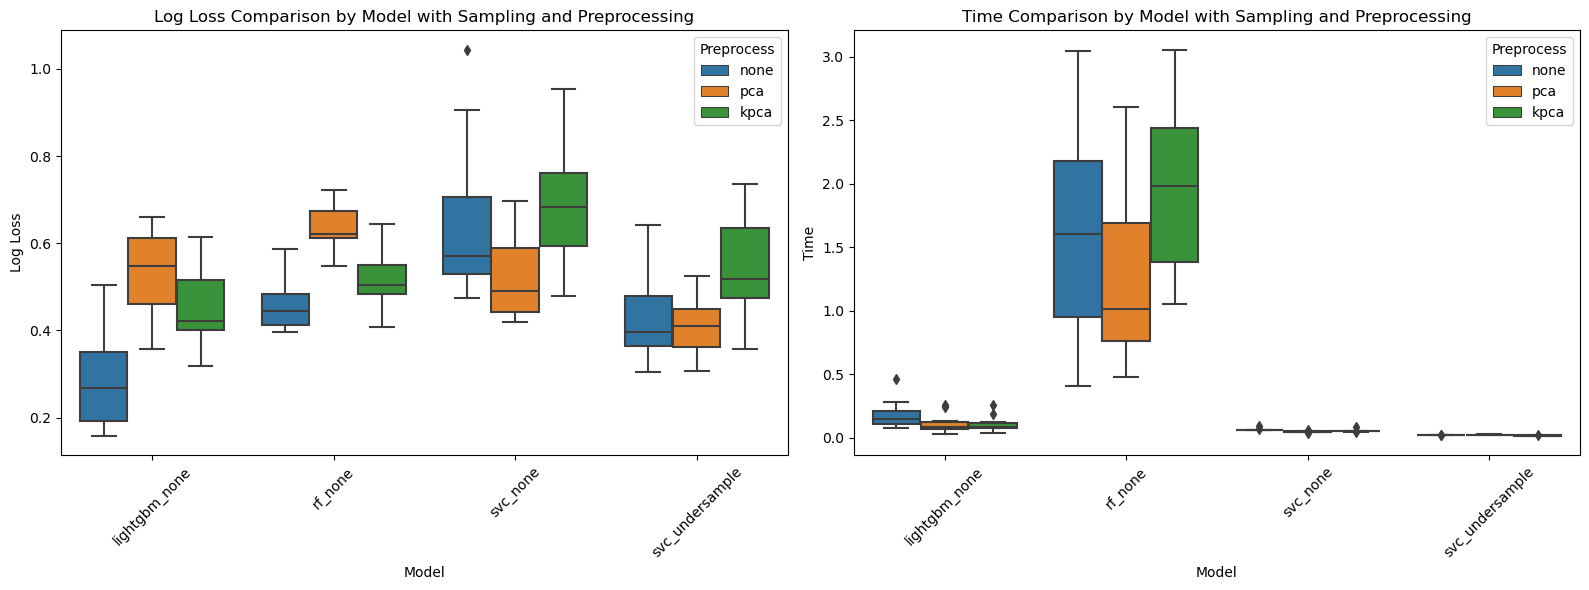

In [5]:
# Adjusting the data to separate models based on their sampling methods
data['model_sampling'] = data['model'] + '_' + data['sample_method']

# Set up the plotting environment
plt.figure(figsize=(16, 6))

# Plot for comparing log_loss across different models, including sampling methods
plt.subplot(1, 2, 1)
sns.boxplot(data=data, x='model_sampling', y='log_loss', hue='preprocess')
plt.title('Log Loss Comparison by Model with Sampling and Preprocessing')
plt.xlabel('Model')
plt.ylabel('Log Loss')
plt.xticks(rotation=45)
plt.legend(title='Preprocess', bbox_to_anchor=(1, 1))

# Plot for comparing time across different models, including sampling methods
plt.subplot(1, 2, 2)
sns.boxplot(data=data, x='model_sampling', y='time', hue='preprocess')
plt.title('Time Comparison by Model with Sampling and Preprocessing')
plt.xlabel('Model')
plt.ylabel('Time')
plt.xticks(rotation=45)
plt.legend(title='Preprocess', bbox_to_anchor=(1, 1))

plt.tight_layout()
plt.show()

**LightGBM achieved the lowest prediction error while maintaining relatively short runtime.** Although SVM demonstrated an advantage in computational efficiency, its prediction error was notably higher. Interestingly, dimensionality reduction appeared to increase prediction error. Based on the feature weights from the dimensionality reduction process and the variable importance analysis in subsequent sections, it is hypothesized that this increase in error is due to the loss of critical feature information during dimensionality reduction, which ultimately led to a decline in prediction accuracy. 

This emphasizes the importance of carefully balancing dimensionality reduction and feature retention when optimizing model performance.

In [8]:
# Load dataset
train_df = pd.read_csv(read_path + "train_20241109.csv")
y_train = train_df['Class']
x_train = train_df.drop(['Class'], axis=True)

# best_params is the dictionary of optimal parameters extracted from Excel
best_params = {'learning_rate': 0.2628299559356277, 
               'num_leaves': 200, 
               'max_depth': 9, 
               'reg_alpha': 1.916650905036856e-08, 
               'reg_lambda': 0.11402447162156922, 
               'bagging_fraction': 0.95, 
               'feature_fraction': 0.9000000000000001, 
               'min_child_samples': 50,
               'n_estimators': 172
              }

# Split the dataset into training and validation sets
x_train_split, x_valid, y_train_split, y_valid = train_test_split(x_train, y_train, test_size=0.2, random_state=3)

# Build the model
model = lgb.LGBMClassifier(
    **best_params,
    class_weight='balanced',
    verbose=-1
)

# Train the model on the split training set
model.fit(
    x_train_split,
    y_train_split,
    eval_metric='binary_logloss'
)

# Predict on the validation set
predictions = model.predict_proba(x_valid)[:, 1]
predicted_classes = model.predict(x_valid)

# Calculate and output multiple evaluation metrics
balanced_log_loss_score = balanced_logarithmic_loss_new(predictions, y_valid)
accuracy = accuracy_score(y_valid, predicted_classes)
precision = precision_score(y_valid, predicted_classes)
recall = recall_score(y_valid, predicted_classes)
f1 = f1_score(y_valid, predicted_classes)
# Output the confusion matrix
conf_matrix = confusion_matrix(y_valid, predicted_classes)

print(f"Balanced Log Loss on validation set: {balanced_log_loss_score}")
print(f"Accuracy on validation set: {accuracy}")
print(f"Precision on validation set: {precision}")
print(f"Recall on validation set: {recall}")
print(f"F1 Score on validation set: {f1}")
print("Confusion Matrix:")
print(conf_matrix)


Balanced Log Loss on validation set: 0.09386245350878039
Accuracy on validation set: 0.967741935483871
Precision on validation set: 0.8
Recall on validation set: 1.0
F1 Score on validation set: 0.8888888888888888
Confusion Matrix:
[[104   4]
 [  0  16]]


1. **Balanced Log Loss on Validation Set: 0.09386245350878039**
   - `Balanced Log Loss` evaluates the accuracy of predicted probabilities by measuring the divergence between predicted probabilities and actual labels. A smaller value indicates better model performance. In this case, the `Balanced Log Loss` is 0.0939, suggesting the model's predicted probabilities align closely with the actual labels.

2. **Accuracy on Validation Set: 0.967741935483871**
   - `Accuracy` represents the proportion of correctly classified samples out of the total samples. An accuracy of 0.9677 indicates that 96.77% of the samples in the validation set were correctly classified, highlighting the model's high overall accuracy.

3. **Precision on Validation Set: 0.8**
   - `Precision` measures the proportion of true positive samples among all samples predicted as positive by the model. A precision of 0.8 means that 80% of the samples predicted as positive were actually positive. A high precision score reflects the model's cautious approach to predicting positive samples, minimizing false positives.

4. **Recall on Validation Set: 1.0**
   - `Recall` quantifies the proportion of true positive samples correctly identified by the model out of all actual positive samples. A recall of 1.0 indicates that the model successfully identified all true positive samples, an ideal result that demonstrates the model's ability to avoid missing any positive cases.

5. **F1 Score on Validation Set: 0.8888888888888888**
   - The `F1 Score` is the harmonic mean of precision and recall, providing a balanced metric that considers both. With an F1 Score of 0.8888, the model achieves a good balance between precision and recall, indicating robust overall performance, particularly in scenarios with class imbalance.

6. **Confusion Matrix: [[104, 4], [0, 16]]**
   - The confusion matrix provides a detailed breakdown of the model's classification results:
     - **`104`**: The number of true negatives (negative samples correctly classified as negative).
     - **`4`**: The number of false positives (negative samples misclassified as positive).
     - **`0`**: The number of false negatives (positive samples misclassified as negative).
     - **`16`**: The number of true positives (positive samples correctly classified as positive).
   - The confusion matrix shows that the model made only a small number of errors on negative samples (4 false positives) and did not miss any positive samples (recall = 1.0).

In summary, the model demonstrates strong performance on the validation set, with high accuracy (96.77%), perfect recall (1.0), and a low `Balanced Log Loss` (0.0939). The confusion matrix highlights the model's ability to identify all positive cases while maintaining a low error rate for negative cases.


**Interpretability is an indispensable aspect of machine learning.** In this study, the importance of variables in the LightGBM model is assessed using Gini Importance, the Permutation Method, and SHAP values.

- Using `model.feature_importances_`, the Gini Importance is calculated for each variable. The results show that the variable `DU` has the greatest cumulative decrease in Gini index across all tree splits, followed by the variable `DA`.
- The Permutation Method, which evaluates the importance of each variable by randomly shuffling its values, also identifies `DU` as the most important variable. Interestingly, in this metric, `BQ` is deemed more important than `DA`, indicating that randomizing `BQ`'s values causes a more significant decline in the model's predictive performance.
- In the SHAP (SHapley Additive exPlanations) analysis, the variable importance ranking highlights `DU` and `AB` as the two most critical variables, underscoring their dominant contribution to the model's predictions.

These findings provide a comprehensive understanding of variable importance across multiple evaluation methods, emphasizing the consistent significance of `DU` while also revealing subtle variations in the importance of other variables depending on the measurement approach.


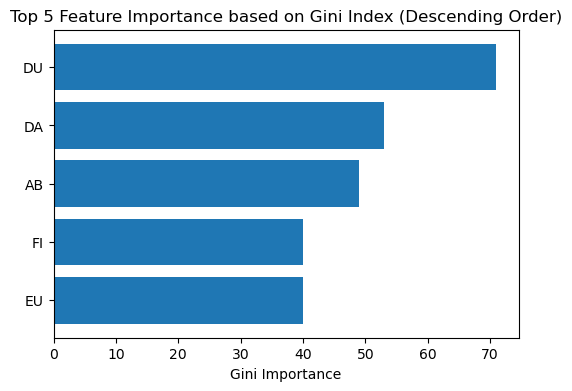

In [14]:
# Gini Importance
# Retrieve Gini importance and sort in descending order
gini_importances = model.feature_importances_
feature_names = x_train_split.columns
gini_importance_df = pd.DataFrame({'Feature': feature_names, 'Gini Importance': gini_importances})
gini_importance_df = gini_importance_df.sort_values(by='Gini Importance', ascending=False)

# Visualize Gini importance (only the top 5 features in descending order)
plt.figure(figsize=(6, 4))
top_5_features = gini_importance_df.head(5)  # Select the top 5 features
plt.barh(top_5_features['Feature'], top_5_features['Gini Importance'])
plt.xlabel("Gini Importance")
plt.title("Top 5 Feature Importance based on Gini Index (Descending Order)")
plt.gca().invert_yaxis()  # Invert the y-axis so the most important feature is at the top
plt.show()


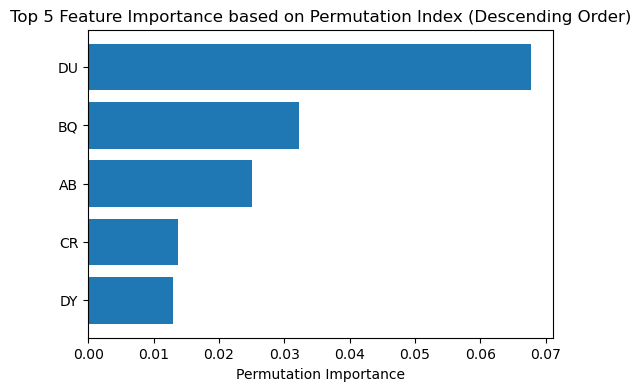

In [15]:
# Permutation Importance
# Evaluate the model's performance on the validation set after permuting specific feature values and sort in descending order
perm_importance = permutation_importance(model, x_valid, y_valid, n_repeats=10, random_state=3)
perm_importance_df = pd.DataFrame({'Feature': feature_names, 'Permutation Importance': perm_importance.importances_mean})
perm_importance_df = perm_importance_df.sort_values(by='Permutation Importance', ascending=False)

# Visualize Permutation Importance (only the top 5 features in descending order)
plt.figure(figsize=(6, 4))
top_5_features = perm_importance_df.head(5)  # Select the top 5 features
plt.barh(top_5_features['Feature'], top_5_features['Permutation Importance'])
plt.xlabel("Permutation Importance")
plt.title("Top 5 Feature Importance based on Permutation Index (Descending Order)")
plt.gca().invert_yaxis()  # Invert the y-axis so the most important feature is at the top
plt.show()


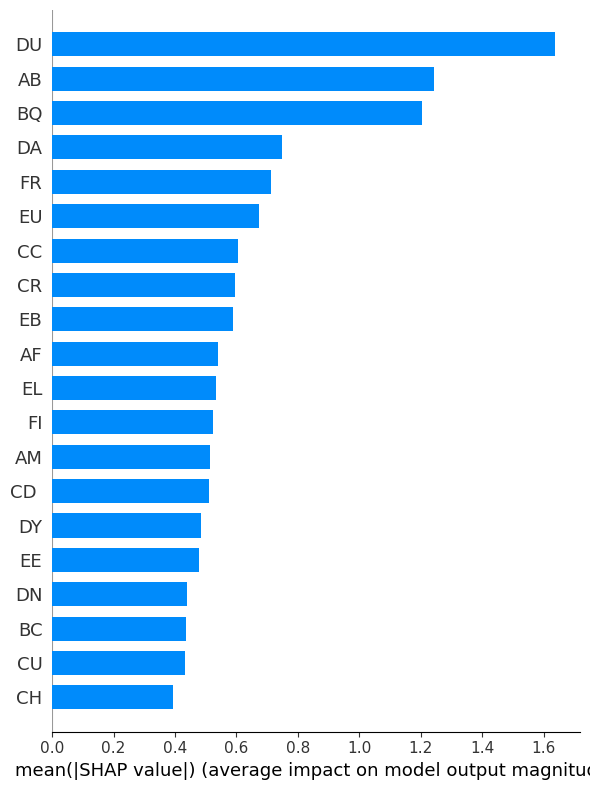

In [9]:
# SHAP value
# Use the SHAP library to calculate SHAP values and sort them in descending order
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(x_valid)
shap.initjs()
shap.summary_plot(shap_values, x_valid, plot_size=[6,8], plot_type='bar')

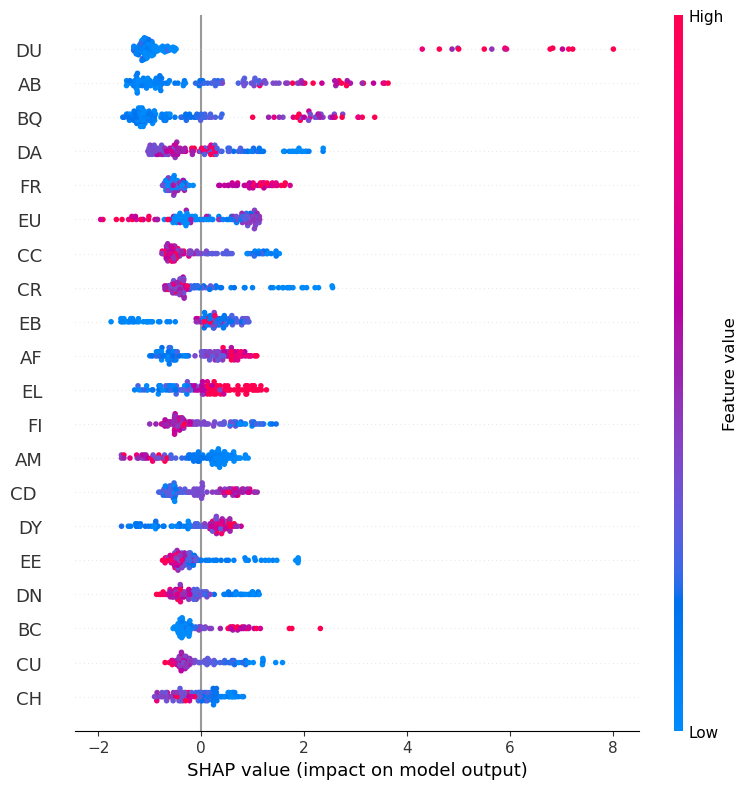

In [17]:
shap.initjs()
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(x_valid)
shap.summary_plot(shap_values, x_valid, plot_size=[8,8], plot_type='dot')

In [10]:
# Visualize the interpretation of the first prediction
shap.initjs()
shap.force_plot(explainer.expected_value, shap_values[0,:], x_valid.iloc[0,:])

**Examining the Impact of Variables on the Prediction of a Single Observation**

For the first observation in the dataset, the contribution of each variable to its prediction was analyzed. Based on the official documentation, the `base value` in the model represents the logarithm of the probability of the positive class (disease presence). The computed `base value` is -13.72, indicating that the average log odds across all samples for class 1 (disease presence) is -13.72.

As shown, for this particular observation:
- The variable `AB` contributes the largest negative deviation from the `base value`, significantly lowering the prediction.
- Conversely, the variable `DI` contributes the largest positive deviation from the `base value`, increasing the prediction.

In this observation, more variables contribute to negative deviations, resulting in a lower predicted probability of disease. These negative contributions align with the lower likelihood of disease predicted for this sample.


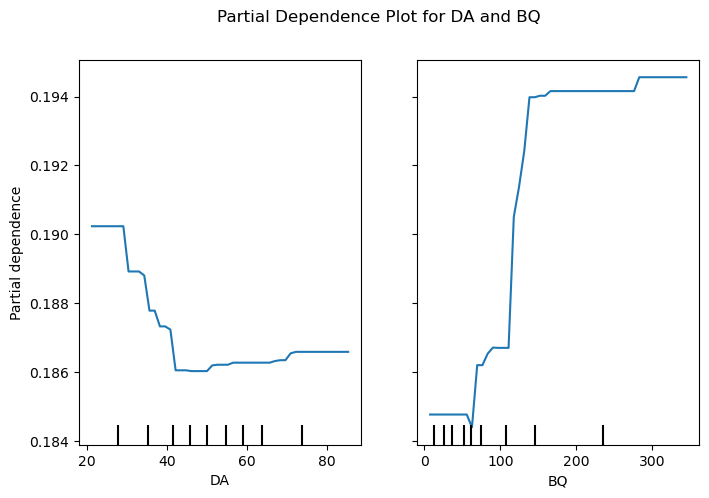

In [19]:
from sklearn.inspection import PartialDependenceDisplay

# Plot partial dependence for DA and BQ
features_to_plot = ['DA', 'BQ']  # Specify the features to plot

# Use PartialDependenceDisplay to create the plots
fig, ax = plt.subplots(figsize=(8, 5))
PartialDependenceDisplay.from_estimator(
    model, 
    X=x_train_split, 
    features=features_to_plot, 
    grid_resolution=50,  # Grid resolution for smoothing the curves
    ax=ax
)
plt.suptitle("Partial Dependence Plot for DA and BQ")
plt.show()



**Partial Dependence Analysis for Variables `DA` and `BQ`**

The partial dependence plots for `DA` and `BQ` reveal their respective impacts on the predicted probability of disease:

- For `DA`, as its value increases, the predicted probability of disease decreases. However, once `DA` exceeds a certain threshold (approximately 40), its influence stabilizes, and further increases no longer affect the prediction. The probability of disease remains constant beyond this point.

- In contrast, the variable `BQ` shows an increasing trend in the predicted probability of disease as its value rises. For lower values of `BQ`, its changes do not affect the prediction significantly. However, once `BQ` surpasses a threshold (around 95), the predicted probability of disease increases sharply. When `BQ` reaches approximately 200, further increases in its value cease to impact the prediction.

These observations suggest that `BQ` may play a critical role in monitoring the progression of the disease, particularly within its sensitive range where its impact on predictions is most pronounced.


# 5. Discussion and Conclusion

Through extensive experimentation with various data preprocessing techniques and machine learning models, the LightGBM model without feature dimensionality reduction demonstrated the best performance. It achieved a balanced log loss of 0.09 on the validation set, making it the most effective approach among those tested.

In the variable interpretation analysis, we identified that the anonymized variables "DU," "BQ," and "DA" significantly influence the predicted probability of disease. Further exploration of these variables revealed their varying impacts on disease risk across different samples. These findings provide valuable insights into assessing an individual's disease risk based on easily measurable physical indicators, contributing to early detection and disease prevention.

Future work could explore advanced ensemble techniques such as Stacking to further enhance model accuracy and robustness.
